# $Regularization\ and\ Symmetry$

In this section, we delineate our mathematical methodology for detecting occlusions from Scalable Vector Graphics (SVG) file Bezier curves. Our approach leverages advanced geometric analysis and computational techniques to achieve precise occlusion detection and infilling.  
#### Methodology:
We have adhered to using traditional mathematical algorithms and computer graphics techniques to correct and regularize shapes, detect the presence of regular shapes inside a plot and to detect axes of symmetry across the regularized plot. We have largely utilized the properties of the cubic bezier curves and focused on contemporary optimization tactics using data structures such as optimal-heap and low-latency undirected graphs to tackle complexity issues.

Our approach can be divided in the following stages:

1. **Processing the Input CSV File and Generating a Fast-Map between Path Index and Points**: The input CSV file needs to undergo a simple preprocessing stage that will selectively map out all required paths and points, making it  easy to trace back used and unused points after the regularizartion step.  
*Complexity*: $\mathbf{O(n)}$ 

2. **Applying the Ramer-Douglas-Peucker Algorithm on Extracted Paths**: Using Ramer-Douglas-Peucker Algorithm we removed all the irregularities and divided each path into a set of polylines from the breakpoints obtained. Using this, we have reduced number of points which need to be handled throughout the process thus optimizing the complexity. This step creates two dictionaries, one for polyline-to-path mapping (newly assumed indices) and one for point-to-polyline mapping.  
*Complexity*: $\mathbf{O(V^{2})}$

3. **Group Close-By Points and Mediate Them**: We have developed a custom algorithm that carries out clusterization and subsequent centroidal value updation to all points in optimum time. This also parallely updates the key values of point-to-polyline mapping.  
*Complexity*: $\mathbf{O(V^{2})}$

4. **Detecting Cycles in the Polylines**:  This step creates a low-latency undirected graph and establishes a relationship between polylines sharing vertices. Using this graph we detect cycles among the polylines. We have used a modified version of the Johnson's Algorithm to detect the cycles.  
*Complexity*: $\mathbf{O((V+E)(C+1))}$

5. **Detect Circles**: We process each loop produced from the previous step, and prioritize the mean square error value for each loop, using an optimal-heap. We have used simple circle fitting algorithm to generate the respective MSE values for each loop. We have considered approximately fifty points on a the fitted circle for calculating MSE. By iterating the heap, we were able to obtain the loops that had the least MS Error, and also remove ambiguity regarding the shared polyline segments in different loops.  
*Complexity*: $\mathbf{O(C*P + Vlog(V))}$ 

6. **Segment Processing**: This step checks the colinearity, slopes and closeliness, and groups polylines based on these parameters. Then while the maintaining the integrety of the original paths, we have simplified these polylines into individual segments. This ensures distinction between ambiguous shapes and straight lines.  
*Complexity*:  $\mathbf{O(V^{2})}$

7. **Polygon Processing and Symmetry Analysis**: This step finds out the high-impact and direction-changing vertices based on the angles, lengths, and the area contributed by the inclusion of that vertex. This ensures that the actual shape and the angles of the loop are preserved even after approximating them. Then by using the same prioritization logic as circles it correctly fits various shapes on the loops. Our MSE function focuses more on the points on the loops, rather than the vertices themselves. This ensures high accuracy and correct shape orientation. This step also carries out analysis of symmetry and provides symetry axes across different regular shapes.  
*Complexity*: $\mathbf{O(N*V + Vlog(V))}$

8. **Return all Un-Processed Curves**: This step simply reverts the original paths from unprocessed polylines using the polyline-to-path and path-to-points dictionaries.  
*Complexity* $\mathbf{O(E*N)}$

#### References:
[1] Ramer, U. (1972). An iterative procedure for the polygonal approximation of plane curves. *Computer Graphics and Image Processing*, 1(3), 244-256.

[2] Johnson, D. B. (1975). Finding all the elementary circuits of a directed graph. *SIAM Journal on Computing*, 4(1), 77-84.

In [1]:
from svgpathtools import svg2paths, Path, Line, CubicBezier, QuadraticBezier, Arc
import numpy as np
import csv
from collections import defaultdict
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import heapq
from scipy.spatial.distance import cdist
import math
from collections import defaultdict
import heapq


### SVG Processing

Given a CSV file containing rows of data in the form:

$ (\text{index}, \text{unused}, x, y) $

This code processes the data to generate a set of tuples:

$ \{ (\text{index}, 0.0000, x, y) \} $

where:
- $\text{index}$ is a categorical or numerical identifier.
- $x$ and $y$ are numerical coordinates.

The resulting collection is a list:

$ \{ (\text{index}_i, 0.0000, x_i, y_i) \, | \, i \in \{1, 2, \dots, N\} \} $

where $N$ is the total number of rows in the CSV file.


In [2]:
class CSVProcessor:
    """
    Processes and loads data points from a CSV file.
    """

    def __init__(self, csv_file: str):
        """
        Initializes with the CSV file path.
        """
        self.csv_file = csv_file
        self.all_points = []

    def load_points_from_csv(self):
        """
        Loads data points from the CSV file into all_points.
        """
        with open(self.csv_file, newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                curve_index = row[0]
                x = float(row[2])
                y = float(row[3])
                self.all_points.append((curve_index, 0.0000, x, y))

### Curve Processing Pipeline

Given a set of curves $\{\text{curve}_i\}$, where each curve $\text{curve}_i$ is a sequence of points $(x_j, y_j)$, this code applies a simplification process based on the Ramer-Douglas-Peucker algorithm with a tolerance $\epsilon$. The resulting set of simplified curves is then further refined by adjusting segment endpoints, particularly when two endpoints are closer than a threshold $T$.

#### Key Operations:

1. **Curve Simplification**: 
   - For each curve $\text{curve}_i = \{(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)\}$, the **Ramer Douglas Peucker** algorithm reduces the number of points while preserving the general shape. This is done by minimizing the perpendicular distance from intermediate points to the line formed by the endpoints.

2. **Segment Endpoints Refinement**:
   - Segments with endpoints closer than $T$ are merged by computing the midpoint $(\frac{x_1 + x_2}{2}, \frac{y_1 + y_2}{2})$ of these endpoints, replacing them in the updated curves.

3. **Final Representation**:
   - The final set of curves, with adjusted endpoints, is stored and can be plotted for visualization.

The overall mathematical process can be summarized as:

$ \{\text{curve}_i\} \rightarrow \text{Simplified Curves} \rightarrow \text{Refined Curves} $

where the simplification minimizes deviations within $\epsilon$, and the refinement ensures that all segment endpoints respect the threshold $T$.


In [3]:
class CurveProcessor:
    """
    Processes curves for simplification and refinement based on given parameters.
    """

    def __init__(self, curves: dict[int, List[Tuple[float, float]]], epsilon: float = 5.0, threshold: float = 5.0):
        """
        Initializes with curves, epsilon for simplification, and threshold for endpoint adjustment.
        """
        self.curves = curves
        self.epsilon = epsilon
        self.threshold = threshold
        self.simplified_curves = {}
        self.inverse_dict = {}
        self.segment_points_dict = {}
        self.updated_curves = {}

    def point_line_distance(self, point, start, end):
        """
        Calculates the perpendicular distance from a point to a line segment.
        """
        point = np.array(point)
        start = np.array(start)
        end = np.array(end)
        
        if np.array_equal(start, end):
            return np.linalg.norm(point - start)
        else:
            n = abs((end[1] - start[1]) * point[0] - (end[0] - start[0]) * point[1] + end[0] * start[1] - end[1] * start[0])
            d = np.linalg.norm(end - start)
            return n / d

    def ramer_douglas_peucker(self, points, epsilon):
        """
        Simplifies a list of points using the Ramer-Douglas-Peucker algorithm.
        """
        dmax = 0.0
        index = 0
        end = len(points)
        for i in range(1, end - 1):
            d = self.point_line_distance(points[i], points[0], points[-1])
            if d > dmax:
                index = i
                dmax = d

        if dmax > epsilon:
            rec_results1, idx1 = self.ramer_douglas_peucker(points[:index+1], epsilon)
            rec_results2, idx2 = self.ramer_douglas_peucker(points[index:], epsilon)
            result = rec_results1[:-1] + rec_results2
            result_indices = idx1[:-1] + [i + index for i in idx2]
        else:
            result = [points[0], points[-1]]
            result_indices = [0, len(points) - 1]

        return result, result_indices

    def simplify_curves(self):
        """
        Simplifies all curves and stores segment information.
        """
        simplified_curves = {}
        inverse_dict = {}
        segment_points_dict = {}
        segment_id = 0

        for index, points in self.curves.items():
            simplified_points, indices = self.ramer_douglas_peucker(points, self.epsilon)

            for i in range(len(simplified_points) - 1):
                start_point = tuple(simplified_points[i])
                end_point = tuple(simplified_points[i + 1])
                line_key = (start_point, end_point)

                segment_indices = indices[i:i+2]
                segment_start_idx = segment_indices[0]
                segment_end_idx = segment_indices[1]

                simplified_curves[segment_id] = [start_point, end_point]
                inverse_dict[line_key] = segment_id
                segment_points_dict[segment_id] = points[segment_start_idx:segment_end_idx+1]

                segment_id += 1

        self.simplified_curves = simplified_curves
        self.inverse_dict = inverse_dict
        self.segment_points_dict = segment_points_dict

    def distance(self, point1, point2):
        """
        Computes the Euclidean distance between two points.
        """
        return np.linalg.norm(np.array(point1) - np.array(point2))

    def midpoint(self, point1, point2):
        """
        Returns the midpoint between two points.
        """
        return ((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2)

    def round_point(self, point):
        """
        Rounds the coordinates of a point to one decimal place.
        """
        return (round(point[0], 1), round(point[1], 1))

    def update_endpoints_with_midpoints(self):
        """
        Adjusts segment endpoints based on proximity and rounds the results.
        """
        endpoints = {}
        updated_curves = {k: v[:] for k, v in self.simplified_curves.items()}
        inverse_dict = {}

        for key, points in self.simplified_curves.items():
            endpoints[key] = (points[0], points[-1])

        for key, (start, end) in endpoints.items():
            if self.distance(start, end) < self.threshold:
                mid = self.midpoint(start, end)
                updated_curves[key][0] = mid
                updated_curves[key][-1] = mid

        for key1, (start1, end1) in endpoints.items():
            for key2, (start2, end2) in endpoints.items():
                if key1 < key2:
                    if self.distance(start1, start2) < self.threshold:
                        mid = self.midpoint(start1, start2)
                        updated_curves[key1][0] = mid
                        updated_curves[key2][0] = mid
                    if self.distance(start1, end2) < self.threshold:
                        mid = self.midpoint(start1, end2)
                        updated_curves[key1][0] = mid
                        updated_curves[key2][-1] = mid
                    if self.distance(end1, start2) < self.threshold:
                        mid = self.midpoint(end1, start2)
                        updated_curves[key1][-1] = mid
                        updated_curves[key2][0] = mid
                    if self.distance(end1, end2) < self.threshold:
                        mid = self.midpoint(end1, end2)
                        updated_curves[key1][-1] = mid
                        updated_curves[key2][-1] = mid

        for key, points in updated_curves.items():
            updated_curves[key] = [self.round_point(point) for point in points]

        for index, points in updated_curves.items():
            for i in range(len(points) - 1):
                start_point = tuple(points[i])
                end_point = tuple(points[i + 1])
                line_key = (start_point, end_point)
                inverse_dict[line_key] = index

        self.updated_curves = updated_curves
        self.inverse_dict = inverse_dict

    def plot_segments(self, curves, inverse_dict, title):
        """
        Plots line segments with labels.
        """
        plt.figure(figsize=(10, 6))
        for (start, end), segment_id in inverse_dict.items():
            x = [start[0], end[0]]
            y = [start[1], end[1]]
            plt.plot(x, y, marker='o', label=f'Segment {segment_id}')
        plt.title(title)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_points(self, curves, title):
        """
        Plots points for all curves.
        """
        plt.figure(figsize=(10, 6))
        for points in curves.values():
            x, y = zip(*points)
            plt.plot(x, y, marker='o', linestyle='None')
        plt.title(title)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.show()

    def process(self):
        """
        Executes curve simplification and endpoint updates.
        """
        self.simplify_curves()
        self.update_endpoints_with_midpoints()


### Cycle Detection

The provided code focuses on detecting cycles in a set of curves. Here's a breakdown using mathematical notation:

Given a set of polylines represented as curves, each curve consists of a sequence of points $\mathbf{P}_i = \{p_1, p_2, \dots, p_n\}$. The goal is to identify cycles within the set of polylines.

1. **Adjacency List Construction:**
   - For each segment between consecutive points $p_i$ and $p_{i+1}$ in the polylines, an undirected graph $G = (V, E)$ is constructed where:
     - $V = \{p_1, p_2, \dots, p_m\}$ represents the vertices (points).
     - $E = \{(p_i, p_{i+1})\}$ represents the edges (line segments).

2. **Cycle Detection:**
   - Using depth-first search (DFS), the algorithm finds all cycles in the graph $G$. A cycle is a closed path $\mathcal{C}$ such that:
     - $\mathcal{C} = \{p_{i_1}, p_{i_2}, \dots, p_{i_k}, p_{i_1}\}$ with $k \geq 3$.
   - The algorithm ensures that each cycle is unique by checking that no two cycles are equivalent as sets of edges.

3. **Non-Cycle Line Segments:**
   - The remaining line segments, which do not belong to any cycle, are identified by comparing the set of all edges $E$ with the set of edges that form cycles $\mathcal{C}$.
   - These non-cycle segments $\mathcal{L}$ are given by:
     - $\mathcal{L} = E \setminus \bigcup_{i} \mathcal{C}_i$

The output consists of the detected cycles $\mathcal{C}$ and the non-cycle segments $\mathcal{L}$.


In [4]:
class CycleDetector:
    """Detects cycles in a set of updated curves."""
    
    def __init__(self, updated_curves: dict[int, List[Tuple[float, float]]]):
        """Initialize with updated curves and construct adjacency list."""
        self.adj_list, self.segments = self.construct_adj_list(updated_curves)

    def construct_adj_list(self, updated_curves):
        """Create an adjacency list and segment list from the updated curves."""
        adj_list = defaultdict(list)
        segments = []
        for polyline in updated_curves.values():
            for i in range(len(polyline) - 1):
                start, end = polyline[i], polyline[i + 1]
                adj_list[start].append(end)
                adj_list[end].append(start)
                segments.append((start, end))
        return adj_list, segments

    def find_cycles(self, graph):
        """Find all cycles in the graph using depth-first search (DFS)."""
        def dfs(node, start, visited, path):
            visited[node] = True
            path.append(node)

            for neighbor in graph[node]:
                if neighbor == start and len(path) > 2:
                    cycle = path[:] + [start]
                    cycles.append(cycle)
                elif not visited[neighbor]:
                    dfs(neighbor, start, visited, path)

            path.pop()
            visited[node] = False

        cycles = []
        visited = defaultdict(bool)

        for node in graph:
            if not visited[node]:
                dfs(node, node, visited, [])

        unique_cycles = []
        for cycle in cycles:
            cycle_set = set(cycle)
            if all(cycle_set != set(c) for c in unique_cycles):
                unique_cycles.append(cycle)

        return unique_cycles

    def separate_non_cycle_lines(self, segments, cycles):
        """Separate non-cycle lines from the segments."""
        cycle_edges = set()
        for cycle in cycles:
            for i in range(len(cycle) - 1):
                edge = tuple(sorted([cycle[i], cycle[i + 1]]))
                cycle_edges.add(edge)

        non_cycle_lines = []
        for start, end in segments:
            edge = tuple(sorted([start, end]))
            if edge not in cycle_edges:
                non_cycle_lines.append((start, end))

        return non_cycle_lines

    def process_cycles(self):
        """Detect cycles and separate non-cycle lines."""
        cycles = self.find_cycles(self.adj_list)
        non_cycle_lines = self.separate_non_cycle_lines(self.segments, cycles)
        return cycles, non_cycle_lines


### Circle Detection and Fitting

The code provides functionality to detect and fit circles to polygons using the least squares method. Here's a detailed explanation with mathematical notation:

#### Point to Segment Distance

The function computes the squared distance from a point \( p \) to a line segment \( vw \). Let \( p \) be a point and \( v \), \( w \) be the endpoints of the segment. The distance is calculated as follows:

1. Compute the squared length \( l^2 \) of the segment \( vw \):
   $
   l^2 = \|v - w\|^2
   $
2. If \( l^2 = 0 \), the segment is a point, and the distance is:
   $
   \text{distance}^2 = \|p - v\|^2
   $
3. Otherwise, compute \( t \), the projection factor:
   $
   t = \max\left(0, \min\left(1, \frac{(p - v) \cdot (w - v)}{l^2}\right)\right)
   $
4. The projection point on the segment is:
   $
   \text{projection} = v + t \cdot (w - v)
   $
5. The squared distance from \( p \) to the segment is:
   $
   \text{distance}^2 = \|p - \text{projection}\|^2
   $

#### Mean Square Circle Error

To evaluate how well a circle fits a polygon, the mean squared error (MSE) is calculated. For a circle centered at \( c \) with radius \( r \), and a polygon:

1. Sample $n$ points along each segment of the polygon.
2. For each sampled point, find the closest point on the circle:
   $
   \text{closest\_point} = c + \frac{p - c}{\|p - c\|} \cdot r
   $
3. Compute the squared distance between the sampled point and the closest point:
   $
   \text{error} = \|p - \text{closest\_point}\|^2
   $
4. Sum the errors and divide by the total number of samples to get the MSE:
   $
   \text{MSE} = \frac{\text{total\_error}}{\text{total\_samples}}
   $

#### Best Fit Circle

To find the best fit circle for a polygon:

1. Randomly select three points from the polygon.
2. Compute the circle passing through these points:
   $
   D = 2 \left(A_x (B_y - C_y) + B_x (C_y - A_y) + C_x (A_y - B_y)\right)
   $
   If \( D \neq 0 \):
   $
   U_x = \frac{(A_x^2 + A_y^2) (B_y - C_y) + (B_x^2 + B_y^2) (C_y - A_y) + (C_x^2 + C_y^2) (A_y - B_y)}{D}
   $
   $
   U_y = \frac{(A_x^2 + A_y^2) (C_x - B_x) + (B_x^2 + B_y^2) (A_x - C_x) + (C_x^2 + C_y^2) (B_x - A_x)}{D}
   $
   $
   \text{Center} = (U_x, U_y)
   $
   $
   \text{Radius} = \| \text{Center} - A \|
   $
3. Evaluate the circle by computing its MSE with the polygon.

#### Circle Detection

1. For each polygon, determine the best fit circle and push it into a min-heap based on MSE.
2. Pop the circle with the smallest MSE:
   - If it contains marked sides, add it to the unused loops.
   - Otherwise, plot the circle and update the marked sides.
3. Filter out polygons with all sides unused to obtain the final list of possible circles.

This approach ensures efficient detection and visualization of circles fitting the given polygons.


In [5]:
class CircleDetector:
    """Detects circles that best fit polygons and identifies remaining sides."""

    def __init__(self, unique_cycles):
        """Initialize with a list of unique cycles.

        Args:
            unique_cycles (list): List of polygons where each polygon is a list of points.
        """
        self.unique_cycles = unique_cycles
        self.remaining_sides = set()
        self.marked_sides = set()

    def point_to_segment_dist(self, p, v, w):
        """Compute the squared distance from point p to the segment vw.

        Args:
            p (np.array): Point for which distance is to be computed.
            v (np.array): One endpoint of the segment.
            w (np.array): The other endpoint of the segment.

        Returns:
            float: Squared distance from p to the segment vw.
        """
        l2 = np.sum((v - w) ** 2)
        if l2 == 0:
            return np.sum((p - v) ** 2)
        t = max(0, min(1, np.dot(p - v, w - v) / l2))
        projection = v + t * (w - v)
        return np.sum((p - projection) ** 2)

    def mean_square_circle_error(self, polygon, center, radius, num_points=10):
        """Calculate the mean squared error of fitting a circle to a polygon.

        Args:
            polygon (list): List of points representing the polygon.
            center (np.array): Center of the circle.
            radius (float): Radius of the circle.
            num_points (int): Number of points to sample per segment.

        Returns:
            float: Mean squared error of the circle fit.
        """
        total_error = 0
        total_samples = 0

        for i in range(len(polygon)):
            p1 = polygon[i]
            p2 = polygon[(i + 1) % len(polygon)]

            segment_points = np.linspace(p1, p2, num_points)

            for point in segment_points:
                closest_point = self.closest_point_on_circle(point, center, radius)
                dist = np.linalg.norm(point - closest_point)
                error = dist ** 2
                total_error += error

            total_samples += len(segment_points)

        mse = total_error / total_samples
        return mse

    def closest_point_on_circle(self, point, center, radius):
        """Find the closest point on the circle to a given point.

        Args:
            point (np.array): Point for which closest circle point is computed.
            center (np.array): Center of the circle.
            radius (float): Radius of the circle.

        Returns:
            np.array: Closest point on the circle to the given point.
        """
        direction = point - center
        direction /= np.linalg.norm(direction)
        return center + direction * radius

    def best_fit_circle(self, polygon):
        """Find the best fit circle for a polygon using random sampling.

        Args:
            polygon (list): List of points representing the polygon.

        Returns:
            tuple: Center (np.array), radius (float), and mean squared error (float) of the best fit circle.
        """
        polygon = np.array(polygon)

        best_mse = float('inf')
        best_center = None
        best_radius = None

        for _ in range(50):
            sample_indices = np.random.choice(len(polygon), 3, replace=False)
            sample_points = polygon[sample_indices]

            A = sample_points[0]
            B = sample_points[1]
            C = sample_points[2]

            D = 2 * (A[0] * (B[1] - C[1]) + B[0] * (C[1] - A[1]) + C[0] * (A[1] - B[1]))
            if D == 0:
                continue

            Ux = ((A[0]**2 + A[1]**2) * (B[1] - C[1]) + (B[0]**2 + B[1]**2) * (C[1] - A[1]) + (C[0]**2 + C[1]**2) * (A[1] - B[1])) / D
            Uy = ((A[0]**2 + A[1]**2) * (C[0] - B[0]) + (B[0]**2 + B[1]**2) * (A[0] - C[0]) + (C[0]**2 + C[1]**2) * (B[0] - A[0])) / D
            center = np.array([Ux, Uy])
            radius = np.linalg.norm(center - A)

            mse = self.mean_square_circle_error(polygon, center, radius)
            if mse < best_mse:
                best_mse = mse
                best_center = center
                best_radius = radius

        return best_center, best_radius, best_mse

    def plot_polygon_and_circle(self, polygon, center, radius, label):
        """Plot the polygon and the best fit circle.

        Args:
            polygon (list): List of points representing the polygon.
            center (np.array): Center of the circle.
            radius (float): Radius of the circle.
            label (str): Label for the circle in the plot.
        """
        polygon = np.array(polygon)
        theta = np.linspace(0, 2 * np.pi, 100)
        circle_x = center[0] + radius * np.cos(theta)
        circle_y = center[1] + radius * np.sin(theta)

        plt.plot(circle_x, circle_y, 'r--', label=label)
        plt.scatter(*center, color='green', zorder=5, label='Center')

    def plot_remaining_sides(self, unique_cycles, marked_sides):
        """Plot remaining sides of polygons that are not marked.

        Args:
            unique_cycles (list): List of polygons where each polygon is a list of points.
            marked_sides (set): Set of marked sides.
        """
        for polygon in unique_cycles:
            polygon = np.array(polygon)
            for i in range(len(polygon)):
                side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
                if side not in marked_sides:
                    plt.plot(*np.array([polygon[i], polygon[(i + 1) % len(polygon)]]).T, 'k-', label='Remaining Side' if i == 0 else "")

    def detect_circles(self):
        """Detect circles fitting the polygons and plot results.

        Returns:
            tuple: A tuple containing two elements:
                - filtered_unused_loops (list): List of polygons that do not fit any circle.
                - possible_circles (list): List of tuples (center, radius, polygon) for possible circles.
        """
        min_heap = []
        possible_circles = []
        unused_loops = []

        for polygon in self.unique_cycles:
            center, radius, mse = self.best_fit_circle(polygon)
            heapq.heappush(min_heap, (mse, center, radius, polygon))

        while min_heap:
            mse, center, radius, polygon = heapq.heappop(min_heap)

            contains_marked_side = False
            for i in range(len(polygon)):
                side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
                if side in self.marked_sides:
                    contains_marked_side = True
                    break

            if contains_marked_side:
                unused_loops.append(polygon)
                continue

            self.plot_polygon_and_circle(polygon, center, radius, label='Best Fit Circle')
            self.plot_remaining_sides(self.unique_cycles, self.marked_sides)
            plt.legend()
            plt.axis('equal')
            plt.show()
            print(f'Mean Square Fitting Error: {mse:.4f}')
            
            if mse < 25:
                possible_circles.append((center, radius, polygon))

                for i in range(len(polygon)):
                    side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
                    self.marked_sides.add(side)
            else:
                unused_loops.append(polygon)

        filtered_unused_loops = []
        for loop in unused_loops:
            all_sides_unused = True
            for i in range(len(loop)):
                side = tuple(sorted([tuple(loop[i]), tuple(loop[(i + 1) % len(loop)])]))
                if side in self.marked_sides:
                    all_sides_unused = False
                    break
            if all_sides_unused:
                filtered_unused_loops.append(loop)

        plt.figure()

        self.plot_remaining_sides(self.unique_cycles, self.marked_sides)
        for polygon in self.unique_cycles:
            polygon = np.array(polygon)
            for i in range(len(polygon)):
                side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
                if side not in self.marked_sides:
                    self.remaining_sides.add(side)

        self.remaining_sides = set([
            ((float(x1), float(y1)), (float(x2), float(y2)))
            for ((x1, y1), (x2, y2)) in self.remaining_sides
        ])

        print("Final Possible Circles are : ")
        for center, radius, polygon in possible_circles:
            self.plot_polygon_and_circle(polygon, center, radius, label='Best Fit Circle')

        plt.legend()
        plt.axis('equal')
        plt.show()

        return filtered_unused_loops, possible_circles


### Segment Processing

In the following sections, we detail the mathematical notations and formulas used in segment processing tasks.

#### 1. Approximate Equality

To determine if two points  $p_1$ and $p_2$ are approximately equal, we use a tolerance $ \text{tol} $. The distance between $ p_1 = (x_1, y_1) $ and $p_2 = (x_2, y_2)$ is calculated using the Euclidean norm:

$ \text{distance} = \| p_1 - p_2 \| = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2} $

We check if this distance is less than the tolerance:

$ \text{are\_approximately\_equal}(p_1, p_2) = \text{distance} < \text{tol} $

#### 2. Computing the Slope

For two points $p_1 = (x_1, y_1) $ and $ p_2 = (x_2, y_2) $, the slope $ m $ of the line passing through these points is given by:

$ m = \frac{y_2 - y_1}{x_2 - x_1} $

If $ x_2 = x_1 $, the line is vertical, and the slope is considered infinite:

$ m = \infty $$

#### 3. Merging Collinear Segments

To merge collinear segments, we consider two segments defined by points $ (x_1, y_1) $ and $ (x_2, y_2) $ and $ (x_3, y_3) $ and $ (x_4, y_4) $. We compute the slope for each segment and merge segments if:

$ \left| \text{compute\_slope}(p_1, p_2) - \text{compute\_slope}(p_3, p_4) \right| < \text{tol} $

#### 4. Determining Segment Extents

For a group of collinear segments, we calculate the minimum and maximum extents along the x and y axes. Given a set of points:

$ \text{all\_points} = \{ (x_i, y_i) \} $

The minimum and maximum indices are computed as follows:

$ \text{min\_idx} = \arg \min_{i} x_i $
$ \text{max\_idx} = \arg \max_{i} x_i $
$\text{min\_y\_idx} = \arg \min_{i} y_i $
$\text{max\_y\_idx} = \arg \max_{i} y_i $

#### 5. Common Vertex Segments

To find segments with common vertices, we compare each segment $ (p_1, p_2) $ with every other segment $ (p_3, p_4) $. If:

$ \text{are\_approximately\_equal}(p_1, p_3) \text{ or } \text{are\_approximately\_equal}(p_1, p_4) \text{ or } \text{are\_approximately\_equal}(p_2, p_3) \text{ or } \text{are\_approximately\_equal}(p_2, p_4) $

Then the segments share a common vertex.

#### 6. Reverting to Original Segments

For segments identified with common vertices, the original segments are retrieved from the merged segments map.

#### 7. Plotting Segments

To visualize segments, we plot them with coordinates:

$ \text{segment} = [(x_1, y_1), (x_2, y_2)] $

Segments are plotted using standard plotting methods with optional highlighting for specific segments.


In [6]:
def are_approximately_equal(p1, p2, tol=5):
    """
    Check if two points are approximately equal within a given tolerance.

    Args:
        p1 (tuple): The first point as (x, y).
        p2 (tuple): The second point as (x, y).
        tol (float): The tolerance for approximation (default is 5).

    Returns:
        bool: True if the distance between the points is less than the tolerance, False otherwise.
    """
    return np.linalg.norm(np.array(p1) - np.array(p2)) < tol

def compute_slope(p1, p2):
    """
    Compute the slope of the line passing through two points.

    Args:
        p1 (tuple): The first point as (x, y).
        p2 (tuple): The second point as (x, y).

    Returns:
        float: The slope of the line. Returns np.inf if the line is vertical.
    """
    if p2[0] == p1[0]:
        return np.inf
    return (p2[1] - p1[1]) / (p2[0] - p1[0])

class SegmentProcessor:
    def __init__(self, segments, tol=1):
        """
        Initialize the SegmentProcessor.

        Args:
            segments (list): A list of segments where each segment is represented as a tuple of two points ((x1, y1), (x2, y2)).
            tol (float): Tolerance for considering segments as collinear (default is 1).
        """
        self.segments = segments
        self.tol = tol
        self.merged_segments = []
        self.map = {}
        self.common_vertex_segments = []
        self.filtered_merged_segments = []

    def merge_collinear_segments(self):
        """
        Merge collinear segments into single segments based on proximity and slope similarity.
        """
        merged_segments = []
        used = set()
        segment_map = {}
        
        while len(used) < len(self.segments):
            for i, (start1, end1) in enumerate(self.segments):
                if i not in used:
                    break

            collinear_group = [(start1, end1)]
            used.add(i)

            while True:
                merged = False
                for j, (start2, end2) in enumerate(self.segments):
                    if j in used:
                        continue
                    
                    if (np.abs(compute_slope(start1, end1) - compute_slope(start2, end2)) < self.tol):
                        if any(are_approximately_equal(start, start2) or 
                               are_approximately_equal(start, end2) or
                               are_approximately_equal(end, start2) or 
                               are_approximately_equal(end, end2) for start, end in collinear_group):
                            collinear_group.append((start2, end2))
                            used.add(j)
                            merged = True

                if not merged:
                    break

            all_points = np.array([point for segment in collinear_group for point in segment])
            min_idx = np.argmin(all_points[:, 0])
            max_idx = np.argmax(all_points[:, 0])
            min_y_idx = np.argmin(all_points[:, 1])
            max_y_idx = np.argmax(all_points[:, 1])

            if np.abs(compute_slope(start1, end1)) < self.tol:
                merged_segments.append((tuple(all_points[min_idx]), tuple(all_points[max_idx])))
                segment_map[(tuple(all_points[min_idx]), tuple(all_points[max_idx]))] = collinear_group
            else:
                segment_map[(tuple(all_points[min_y_idx]), tuple(all_points[max_y_idx]))] = collinear_group
                merged_segments.append((tuple(all_points[min_y_idx]), tuple(all_points[max_y_idx])))

        self.merged_segments = merged_segments
        self.map = segment_map

    def find_segments_with_common_vertices(self):
        """
        Identify segments from the merged segments that share common vertices.

        Returns:
            list: A list of segments that have common vertices.
        """
        common_vertex_segments = []
        for i, (start1, end1) in enumerate(self.merged_segments):
            for j, (start2, end2) in enumerate(self.merged_segments):
                if i != j:
                    if are_approximately_equal(start1, start2, self.tol) or are_approximately_equal(start1, end2, self.tol) or \
                       are_approximately_equal(end1, start2, self.tol) or are_approximately_equal(end1, end2, self.tol):
                        common_vertex_segments.append((start1, end1))
                        break
        self.common_vertex_segments = common_vertex_segments

    def revert_to_original_segments(self):
        """
        Revert the merged segments back to their original segments.

        Returns:
            list: A list of original segments corresponding to the common vertex segments.
        """
        reverted_segments = []
        for segment in self.common_vertex_segments:
            reverted_segments += self.map[segment]
        return reverted_segments

    def filter_merged_segments(self):
        """
        Filter out the merged segments that are also in the list of common vertex segments.
        """
        self.filtered_merged_segments = [seg for seg in self.merged_segments if seg not in self.common_vertex_segments]

    def plot_segments(self, segments, title, highlight_segments=None):
        """
        Plot segments with an optional highlight for specific segments.

        Args:
            segments (list): A list of segments where each segment is represented as a tuple of two points ((x1, y1), (x2, y2)).
            title (str): Title of the plot.
            highlight_segments (list, optional): Segments to be highlighted in a different color (default is None).
        """
        plt.figure(figsize=(10, 8))
        for (start, end) in segments:
            plt.plot([start[0], end[0]], [start[1], end[1]], marker='o', color='blue')
        if highlight_segments:
            for (start, end) in highlight_segments:
                plt.plot([start[0], end[0]], [start[1], end[1]], marker='o', color='red')
        plt.title(title)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.show()


### Polygon Detection and Fitting Algorithm

The `PolygonDetection` class implements a sophisticated method for detecting and fitting polygons based on a set of points and line segments. The class offers a variety of utilities for processing these geometric shapes. Below, we will delve into the mathematical foundations of some key methods.

### 1. Sampling Points Along a Segment

Given two points $p_1 = (x_1, y_1)$ and $p_2 = (x_2, y_2)$, we can generate a set of `num_points` linearly spaced points along the segment connecting $p_1$ and $p_2$:

$
\text{Sampled Points} = \left\{ p_i \mid p_i = \frac{i}{\text{num\_points} - 1} \cdot p_2 + \left(1 - \frac{i}{\text{num\_points} - 1}\right) \cdot p_1, \, i = 0, 1, \ldots, \text{num\_points} - 1 \right\}
$


#### 2. Calculating the Angle Between Two Lines

For two line segments defined by endpoints $(x_1, y_1)$ to $(x_2, y_2)$ and $(x_3, y_3)$ to $(x_4, y_4)$, the vectors corresponding to these segments are:

$
\mathbf{v}_1 = \left( x_2 - x_1, y_2 - y_1 \right), \quad \mathbf{v}_2 = \left( x_4 - x_3, y_4 - y_3 \right)
$

The angle $\theta$ between these vectors can be computed using the dot product:

$
\cos \theta = \frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{\|\mathbf{v}_1\| \|\mathbf{v}_2\|}
$

Where $\|\mathbf{v}_1\|$ and $\|\mathbf{v}_2\|$ are the magnitudes of the vectors. The angle $\theta$ is then:

$
\theta = \cos^{-1}\left(\min\left(\max\left(\frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{\|\mathbf{v}_1\| \|\mathbf{v}_2\|}, -1\right), 1\right)\right)
$

#### 3. Calculating the Area Contribution of a Triangle

The signed area of a triangle formed by three points $p_1 = (x_1, y_1)$, $p_2 = (x_2, y_2)$, and $p_3 = (x_3, y_3)$ can be computed using the determinant:

$
\text{Area} = \frac{1}{2} \left| x_1(y_2 - y_3) + x_2(y_3 - y_1) + x_3(y_1 - y_2) \right|
$

This area is used to determine the significance of vertices in polygon fitting.

#### 4. Internal Angle Calculation

The internal angle $\theta$ at a vertex $p_2$ between two segments $p_1 \rightarrow p_2$ and $p_2 \rightarrow p_3$ is given by:

$
\cos \theta = \frac{(p_2 - p_1) \cdot (p_3 - p_2)}{\|p_2 - p_1\| \cdot \|p_3 - p_2\|}
$

Where $\theta = \cos^{-1}\left(\min\left(\max\left(\frac{(p_2 - p_1) \cdot (p_3 - p_2)}{\|p_2 - p_1\| \cdot \|p_3 - p_2\|}, -1\right), 1\right)\right)$.

#### 5. Best Fit Polygon Calculation

To find the best-fit regular polygon for a given set of vertices, the algorithm minimizes a fitting score. The vertices are approximated by a regular polygon with the same centroid and average radius, $r$, given by:

$
r = \frac{1}{N} \sum_{i=1}^{N} \|p_i - \text{Centroid}\|
$

Where $N$ is the number of vertices. The fitting score is computed by minimizing the sum of distances between the actual vertices and the approximate polygon vertices.

#### 6. Filter Points by Distance

Points are filtered based on their distance from each other. For a set of points $\{p_1, p_2, \ldots, p_n\}$, the average distance $d_{\text{avg}}$ between consecutive points is computed, and points with distances below a threshold $0.85 \times d_{\text{avg}}$ are filtered out.

#### 7. Plotting Lines of Symmetry

For each detected polygon or shape, lines of symmetry are plotted, depending on the type of shape (e.g., polygon, star, or rectangle). Symmetry lines are determined by either connecting opposite vertices or bisecting the shape along its centroid.



In [7]:
class PolygonDetection:
    def __init__(self, error_threshold=150):
        self.error_threshold = error_threshold
        self.polygons = []
        
    def sample_points_along_segment(self, p1, p2, num_points=10):
        return np.linspace(p1, p2, num_points)

    def calculate_angle_between_lines(self, line1, line2):
        def vector_from_line(line):
            (x1, y1), (x2, y2) = line
            return (x2 - x1, y2 - y1)

        common_points = set(line1) & set(line2)
        if len(common_points) == 0:
            return None

        vec1 = vector_from_line(line1)
        vec2 = vector_from_line(line2)

        magnitude1 = math.sqrt(vec1[0]**2 + vec1[1]**2)
        magnitude2 = math.sqrt(vec2[0]**2 + vec2[1]**2)

        if magnitude1 == 0 or magnitude2 == 0:
            return None

        dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
        cos_theta = dot_product / (magnitude1 * magnitude2)

        cos_theta = min(1, max(-1, cos_theta))

        angle = math.degrees(math.acos(cos_theta))
        return angle

    def are_points_close(self, p1, p2, tolerance=1):
        return np.linalg.norm(np.array(p1) - np.array(p2)) < tolerance

    def calculate_area_contribution(self, p1, p2, p3):
        """Calculate the signed area of the triangle formed by p1, p2, p3."""
        return 0.5 * abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))

    def calculate_internal_angle(self, p1, p2, p3):
        vec1 = np.array(p2) - np.array(p1)
        vec2 = np.array(p3) - np.array(p2)
        dot_product = np.dot(vec1, vec2)
        magnitude1 = np.linalg.norm(vec1)
        magnitude2 = np.linalg.norm(vec2)
        if magnitude1 == 0 or magnitude2 == 0:
            return 0
        cos_theta = dot_product / (magnitude1 * magnitude2)
        cos_theta = min(1, max(-1, cos_theta))
        return math.degrees(math.acos(cos_theta))

    def process_polygons(self, polygons):
        vertices_arr = []
        lines_arr = []

        for points in polygons:
            lines = [(points[i], points[(i + 1) % len(points)]) for i in range(len(points))]

            concave_vertices = []
            for i in range(len(points)):
                p_prev = points[i - 1]
                p_curr = points[i]
                p_next = points[(i + 1) % len(points)]
                angle = self.calculate_internal_angle(p_prev, p_curr, p_next)
                if angle > 180:
                    concave_vertices.append(p_curr)

            points = [p for p in points if p not in concave_vertices]

            points = self.filter_points(np.array(points))
            heap = []
            for i in range(len(points)):
                p_prev = points[i - 1]
                p_curr = points[i]
                p_next = points[(i + 1) % len(points)]
                area_contribution = self.calculate_area_contribution(p_prev, p_curr, p_next)
                heapq.heappush(heap, (-area_contribution, p_curr))

            vertices = set()
            while heap:
                score, vertex = heapq.heappop(heap)
                vertex_tuple = tuple(vertex)  # Convert numpy array to a tuple
                if not any(self.are_points_close(vertex, np.array(v)) for v in vertices):
                    vertices.add(vertex_tuple)

            vertices = np.array([np.array(v) for v in vertices])
            vertices_arr.append(vertices)
            lines_arr.append(lines)
        return vertices_arr, lines_arr
    
    def calculate_distance(self, p1, p2):
        """Calculate the Euclidean distance between two points."""
        return np.linalg.norm(p2 - p1)

    def filter_points(self, points):
        distances = [self.calculate_distance(points[i], points[(i+1) % len(points)]) for i in range(len(points))]
        avg_distance = np.mean(distances)
        threshold = 0.85 * avg_distance
        i = 0
        while i < len(points):
            if distances[i] < threshold:
                dist_prev = self.calculate_distance(points[(i-1 + len(points)) % len(points)], points[i])
                dist_next = self.calculate_distance(points[(i+1) % len(points)], points[(i+2) % len(points)])
                
                if dist_prev <= dist_next:
                    points = np.delete(points, i, axis=0)
                else:
                    points = np.delete(points, (i+1) % len(points), axis=0)
                
                distances = [self.calculate_distance(points[j], points[(j+1) % len(points)]) for j in range(len(points))]
            else:
                i += 1
        
        return points

    def calculate_angle(self, point, centroid):
        return np.arctan2(point[1] - centroid[1], point[0] - centroid[0])

    def get_best_fit_polygon(self, vertices, lines):
        centroid = np.mean(vertices, axis=0)
        distances = np.linalg.norm(vertices - centroid, axis=1)
        average_radius = np.mean(distances)
        n_vertices = len(vertices)

        def generate_regular_polygon(centroid, radius, n_vertices, rotation_angle=0):
            angles = np.linspace(0, 2 * np.pi, n_vertices, endpoint=False) + rotation_angle
            return np.array([
                [centroid[0] + radius * np.cos(angle), centroid[1] + radius * np.sin(angle)]
                for angle in angles
            ])

        def fit_score(vertices, approx_vertices):
            return np.sum(cdist(vertices, approx_vertices, 'euclidean').min(axis=1))

        def line_fit_score(lines, approx_vertices):
            total_distance = 0
            total_samples = 0

            for line in lines:
                p1, p2 = line
                segment_points = self.sample_points_along_segment(p1, p2)
                distances = cdist(segment_points, approx_vertices, 'euclidean').min(axis=1)
                total_distance += np.sum(distances)
                total_samples += len(distances)

            return total_distance / total_samples

        best_fit_polygon = None
        best_fit_score = float('inf')
        best_rotation_angle = 0
        best_radius = average_radius

        radii = np.linspace(average_radius - 1, average_radius + 1, 3)
        for radius in radii:
            for angle in np.linspace(0, 2 * np.pi, 360):
                approx_vertices = generate_regular_polygon(centroid, radius, n_vertices, rotation_angle=angle)
                vertex_score = fit_score(vertices, approx_vertices)
                line_score = line_fit_score(lines, approx_vertices)
                score = vertex_score + line_score
                if score < best_fit_score:
                    best_fit_score = score
                    best_fit_polygon = approx_vertices
                    best_rotation_angle = angle
                    best_radius = radius

        return best_fit_polygon, best_rotation_angle, best_radius

    def get_best_fit_rectangle(self, vertices, lines):
        if len(vertices) != 4:
            return None, None, None  
        side_lengths = np.array([np.linalg.norm(vertices[i] - vertices[(i+1) % 4]) for i in range(4)])

        if not (np.isclose(side_lengths[0], side_lengths[2], rtol=0.1) and np.isclose(side_lengths[1], side_lengths[3], rtol=0.1)):
            return None, None, None

        min_adjacent_ratio = np.min(side_lengths) / np.max(side_lengths)
        if min_adjacent_ratio > 0.5:
            return None, None, None

        centroid = np.mean(vertices, axis=0)
        
        best_rotation_angle = 0  # Placeholder for rotation calculation

        rectangle_vertices = np.array([
            centroid + np.array([-side_lengths[0] / 2, -side_lengths[1] / 2]),
            centroid + np.array([side_lengths[0] / 2, -side_lengths[1] / 2]),
            centroid + np.array([side_lengths[0] / 2, side_lengths[1] / 2]),
            centroid + np.array([-side_lengths[0] / 2, side_lengths[1] / 2])
        ])

        return rectangle_vertices, best_rotation_angle, None 

    def get_best_fit_star_shape(self, vertices, lines):
        centroid = np.mean(vertices, axis=0)

        distances = np.linalg.norm(vertices - centroid, axis=1)

        angles = np.arctan2(vertices[:, 1] - centroid[1], vertices[:, 0] - centroid[0])
        sorted_indices = np.argsort(angles)
        sorted_vertices = vertices[sorted_indices]

        outer_vertices = sorted_vertices[::2]
        inner_vertices = sorted_vertices[1::2]

        star_points = np.empty((len(vertices), 2))
        star_points[::2] = outer_vertices
        star_points[1::2] = inner_vertices

        best_rotation_angle = 0  
        best_radius = np.mean(distances[sorted_indices[::2]])
        return star_points, best_rotation_angle, best_radius


    def process_polygons_with_fit(self, vertices_list, lines_list):
        valid_polygons = []
        rejected_polygons = []
        remaining_segments = []

        for vertices, lines in zip(vertices_list, lines_list):
            best_fit_polygon, best_rotation_angle, best_radius = None, None, None
            if len(vertices) == 0 or len(lines) == 0:
                continue

            polygon_type = "polygon"

            if len(vertices) % 2 == 0 and len(vertices) >= 8:
                best_fit_polygon, best_rotation_angle, best_radius = self.get_best_fit_star_shape(vertices, lines)
                if best_fit_polygon is None:
                    best_fit_polygon, best_rotation_angle, best_radius = self.get_best_fit_polygon(vertices, lines)
                else:
                    polygon_type = "star"
                    
            elif len(vertices) == 4:
                best_fit_polygon, best_rotation_angle, _ = self.get_best_fit_rectangle(vertices, lines)
                if best_fit_polygon is not None:
                    polygon_type = "rectangle"
                else:
                    best_fit_polygon, best_rotation_angle, best_radius = self.get_best_fit_polygon(vertices, lines)

            else:
                best_fit_polygon, best_rotation_angle, best_radius = self.get_best_fit_polygon(vertices, lines)

            line_errors = []
            for line in lines:
                p1, p2 = line
                segment_points = self.sample_points_along_segment(p1, p2)
                distances = cdist(segment_points, best_fit_polygon, 'euclidean').min(axis=1)
                line_errors.append(np.mean(distances))

            if any(error > self.error_threshold for error in line_errors):
                rejected_polygons.append((vertices, lines))
                for line in lines:
                    remaining_segments.append(line)
                continue

            # Store the valid polygon with its type
            valid_polygons.append((best_fit_polygon, best_rotation_angle, best_radius, polygon_type))

        self.polygons = valid_polygons  # Store the valid polygons
        return valid_polygons, rejected_polygons, remaining_segments

    def plot_all_polygons_with_symmetry(self):
        """
        Plot all the stored polygons along with their lines of symmetry.
        """
        for polygon_data in self.polygons:
            polygon_vertices, rotation_angle, radius, polygon_type = polygon_data
            self.plot_lines_of_symmetry(polygon_vertices, polygon_type=polygon_type)

    def plot_lines_of_symmetry(self, polygon_vertices, polygon_type="polygon"):
        """
        Plot lines of symmetry for regular polygons and rectangles.

        :param polygon_vertices: Array of vertices for the polygon/rectangle.
        :param polygon_type: Type of polygon, either "polygon" or "rectangle".
        """
        centroid = np.mean(polygon_vertices, axis=0)
        
        plt.figure(figsize=(6, 6))
        plt.plot(*polygon_vertices.T, 'r-', label='Polygon')
        plt.plot([polygon_vertices[-1, 0], polygon_vertices[0, 0]],
                [polygon_vertices[-1, 1], polygon_vertices[0, 1]], 'r-')

        plt.plot(centroid[0], centroid[1], 'ro', label='Centroid')

        if polygon_type == "polygon" or polygon_type == "star":
            for vertex in polygon_vertices:
                plt.plot([vertex[0], centroid[0]], [vertex[1], centroid[1]], 'g--', label='Line of Symmetry')

            if len(polygon_vertices) % 2 == 0 and polygon_type == "polygon":
                num_vertices = len(polygon_vertices)
                for i in range(num_vertices // 2):
                    opposite_vertex = polygon_vertices[(i + num_vertices // 2) % num_vertices]
                    plt.plot([polygon_vertices[i][0], opposite_vertex[0]],
                            [polygon_vertices[i][1], opposite_vertex[1]], 'b--', label='Bisecting Line')

                for i in range(num_vertices):
                    next_i = (i + 1) % num_vertices
                    midpoint = (polygon_vertices[i] + polygon_vertices[next_i]) / 2
                    opposite_midpoint = (polygon_vertices[(i + num_vertices // 2) % num_vertices] +
                                        polygon_vertices[(next_i + num_vertices // 2) % num_vertices]) / 2
                    plt.plot([midpoint[0], opposite_midpoint[0]], [midpoint[1], opposite_midpoint[1]], 'r--', label='Perpendicular Bisector')

        elif polygon_type == "rectangle":
            diagonals = [
                (polygon_vertices[0], polygon_vertices[2]),
                (polygon_vertices[1], polygon_vertices[3])
            ]
            for diagonal in diagonals:
                plt.plot([diagonal[0][0], diagonal[1][0]], [diagonal[0][1], diagonal[1][1]], 'g--', label='Diagonal')

            for i in range(2):
                midpoint = (polygon_vertices[i] + polygon_vertices[(i+2) % 4]) / 2
                plt.plot([midpoint[0], centroid[0]], [midpoint[1], centroid[1]], 'b--', label='Midline')
        
        plt.axis('equal')
        plt.legend()
        plt.title('Lines of Symmetry')
        plt.show()


    def handle_remaining_segments(self, remaining_segments):
        heapq.heapify(remaining_segments)
        final_polygons = []
        utilized_segments = set()

        while remaining_segments:
            current_segment = heapq.heappop(remaining_segments)
            if any(tuple(map(tuple, segment)) in utilized_segments for segment in current_segment):
                continue

            remaining_polygons = [segment for segment in current_segment if tuple(map(tuple, segment)) not in utilized_segments]

            if len(remaining_polygons) == 0:
                continue

            vertices = np.array([point for segment in remaining_polygons for point in segment])
            lines = remaining_polygons
            best_fit_polygon, best_rotation_angle, best_radius = self.get_best_fit_polygon(vertices, lines)

            line_errors = []
            for line in lines:
                p1, p2 = line
                segment_points = self.sample_points_along_segment(p1, p2)
                distances = cdist(segment_points, best_fit_polygon, 'euclidean').min(axis=1)
                line_errors.append(np.mean(distances))

            if any(error > self.error_threshold for error in line_errors):
                for line in lines:
                    remaining_segments.append(line)
                continue

            final_polygons.append((best_fit_polygon, best_rotation_angle, best_radius))
            for segment in lines:
                utilized_segments.add(tuple(map(tuple, segment)))

        return final_polygons


### Regularization and Symmetry

This code puts everything together. We have tested all provided testcases provided below.

In [8]:
def regularize(path, xlim=None, ylim=None):
    csv_processor = CSVProcessor(csv_file=path)
    csv_processor.load_points_from_csv()

    curves = defaultdict(list)
    for point in csv_processor.all_points:
        curve_index, _, x, y = point
        curves[curve_index].append((x, y))

    curve_processor = CurveProcessor(curves)
    curve_processor.process()
    curves = curve_processor.segment_points_dict

    cycle_detector = CycleDetector(curve_processor.updated_curves)
    cycles, non_cycle_lines = cycle_detector.process_cycles()
  
    circle_detector = CircleDetector(cycles)
    print("\ntry to fit circle in loops : \n")
    remaining_sides = circle_detector.remaining_sides
    filtered_unused_loops, possible_circles = circle_detector.detect_circles()
   

    unique_cycles = circle_detector.unique_cycles

    for loop in filtered_unused_loops:
        for polygon in unique_cycles:
            for i in range(len(polygon)):
                side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
                remaining_sides.add(side)

    # Remove sides in possible_circles
    for _, _, polygon in possible_circles:
        for i in range(len(polygon)):
            side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
            if side in remaining_sides:
                remaining_sides.remove(side)

    # Remove sides in filtered_unused_loops
    for polygon in filtered_unused_loops:
        for i in range(len(polygon)):
            side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
            if side in remaining_sides:
                remaining_sides.remove(side)

    segments = list(non_cycle_lines)

    segment_processor = SegmentProcessor(segments)
    segment_processor.merge_collinear_segments()
    segment_processor.find_segments_with_common_vertices()
    rem = segment_processor.revert_to_original_segments()
    segment_processor.filter_merged_segments()

    segment_processor.plot_segments(segment_processor.filtered_merged_segments, "Merged Segments Excluding Common Vertices")
    segment_processor.plot_segments(rem, "Original Segments with Common Vertices")
    remaining_sides = remaining_sides.union(set(rem))
    polygon_detection = PolygonDetection()
    vertices_arr, lines_arr = polygon_detection.process_polygons(filtered_unused_loops)
    if xlim!=None and ylim!= None:
            plt.xlim(-50, ylim)
            plt.ylim(-50, ylim)
    if len(vertices_arr) > 0 or len(lines_arr) > 0 or len(filtered_unused_loops) > 0 :
        print("Impact Points in current loop are : ")
        plt.figure(figsize=(10, 10))
        for vertices in vertices_arr:
            if len(vertices) > 0:  
                plt.plot(vertices[:, 0], vertices[:, 1], 'o', label='Processed Vertices')

        for lines in lines_arr:
            for line in lines:
                x_values, y_values = zip(*line)
                plt.plot(x_values, y_values, 'k--', alpha=0.5)

        for points in filtered_unused_loops:
            plt.plot([p[0] for p in points], [p[1] for p in points], 'x--', label='Original Points')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Impact Points')
        plt.legend()
        plt.grid(True)
        plt.show()

    valid_polygons, rejected_polygons, remaining_segments = polygon_detection.process_polygons_with_fit(vertices_arr, lines_arr)
    polygon_detection.plot_all_polygons_with_symmetry()
    final_polygons = polygon_detection.handle_remaining_segments(remaining_segments)

    if len(valid_polygons) > 0 or len(final_polygons) > 0 : 
        plt.figure(figsize=(10, 10))
        for best_fit_polygon, best_rotation_angle, best_radius, polygon_type in valid_polygons:
            plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
                    np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'ro-', label='Best Fit Polygon')

        for best_fit_polygon, best_rotation_angle, best_radius in final_polygons:
            plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
                    np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'go-', label='Final Polygon')
            
        if xlim!=None and ylim!= None:
            plt.xlim(-50, ylim)
            plt.ylim(-50, ylim)
        plt.legend()
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Approximated Polygons')
        plt.grid(True)
        plt.show()


    def plot_all(valid_polygons, possible_circles, remaining_sides, curves, inverse_dict, merged_segments):
        plt.figure(figsize=(12, 12))
        remaining_sides = set([
            ((float(x1), float(y1)), (float(x2), float(y2)))
            for ((x1, y1), (x2, y2)) in remaining_sides
        ])

        all_x = []
        all_y = []

        for best_fit_polygon, best_rotation_angle, best_radius, polygon_type in valid_polygons:
            all_x.extend(best_fit_polygon[:, 0])
            all_y.extend(best_fit_polygon[:, 1])
            plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
                    np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'ro-', label='Best Fit Polygon')

        for center, radius, circle_points in possible_circles:
            circle = plt.Circle(center, radius, color='b', fill=False)
            plt.gca().add_artist(circle)
            all_x.append(center[0] + radius)
            all_x.append(center[0] - radius)
            all_y.append(center[1] + radius)
            all_y.append(center[1] - radius)
            circle_points = np.array(circle_points)
            all_x.extend(circle_points[:, 0])
            all_y.extend(circle_points[:, 1])

        plotted_curves = set()
        
        for side in remaining_sides:
            if side in inverse_dict:
                curve_num = inverse_dict[side]
            elif (side[1], side[0]) in inverse_dict:
                curve_num = inverse_dict[(side[1], side[0])]
            else:
                continue
            
            if curve_num not in plotted_curves:
                if curve_num in curves:
                    points = curves[curve_num]
                    x_values, y_values = zip(*points)
                    all_x.extend(x_values)
                    all_y.extend(y_values)
                    plt.plot(x_values, y_values, label=f'Curve {curve_num}')
                    plotted_curves.add(curve_num)

            

        for segment in merged_segments:
            (x1, y1), (x2, y2) = segment
            all_x.extend([x1, x2])
            all_y.extend([y1, y2])
            plt.plot([x1, x2], [y1, y2], 'g-', label='Merged Segment')

        if xlim!=None and ylim!= None:
            plt.xlim(-50, ylim)
            plt.ylim(-50, ylim)
        plt.legend()
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Regularized Shapes')
        plt.grid(True)
        plt.show()

    if xlim!=None and ylim!= None:
            plt.xlim(-50, ylim)
            plt.ylim(-50, ylim)
    plot_all(valid_polygons, possible_circles, remaining_sides, curves, curve_processor.inverse_dict, segment_processor.filtered_merged_segments)



# OUTPUT

Test Case Name: **frag0**


try to fit circle in loops : 



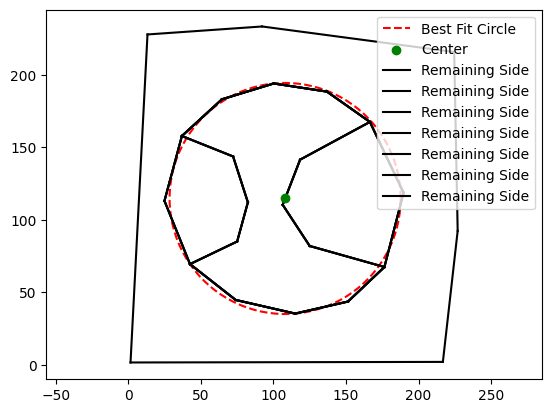

Mean Square Fitting Error: 4.1028


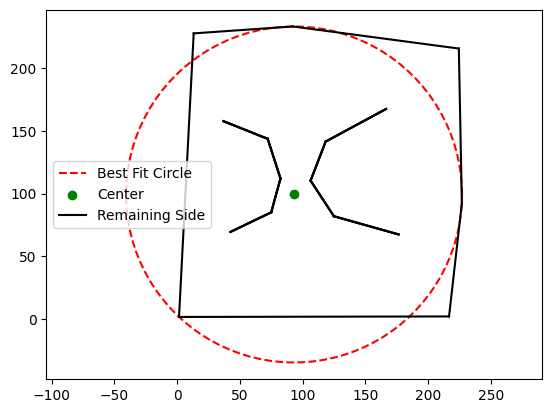

Mean Square Fitting Error: 396.8849
Final Possible Circles are : 


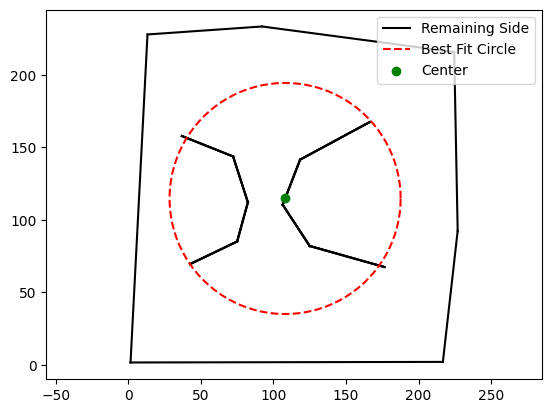

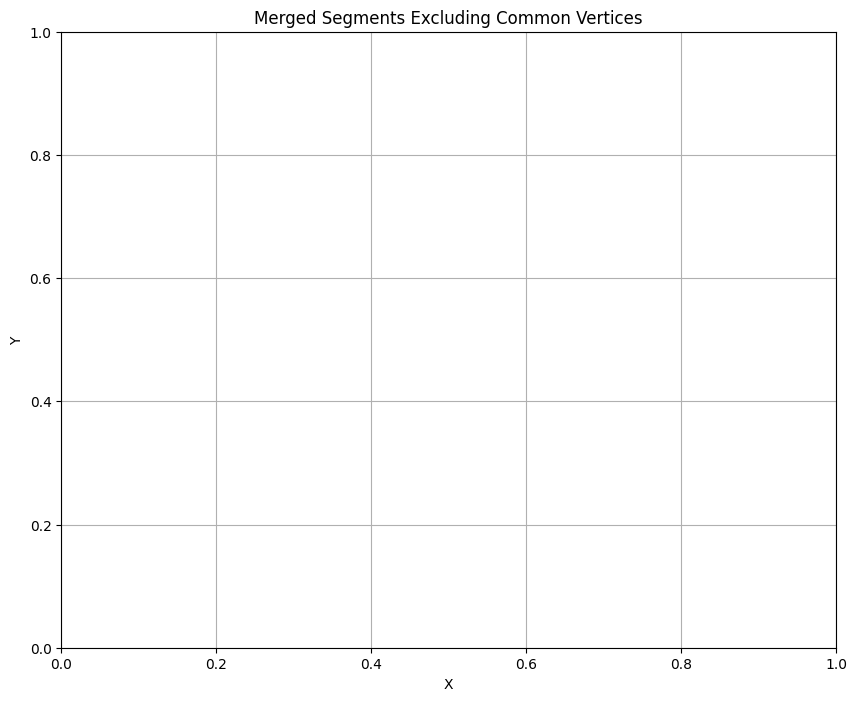

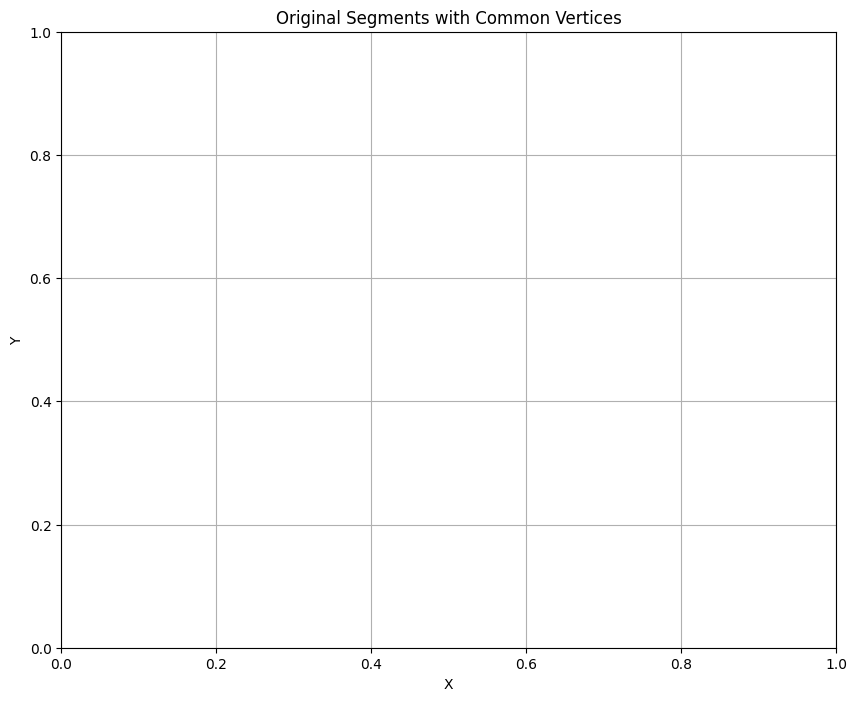

Impact Points in current loop are : 


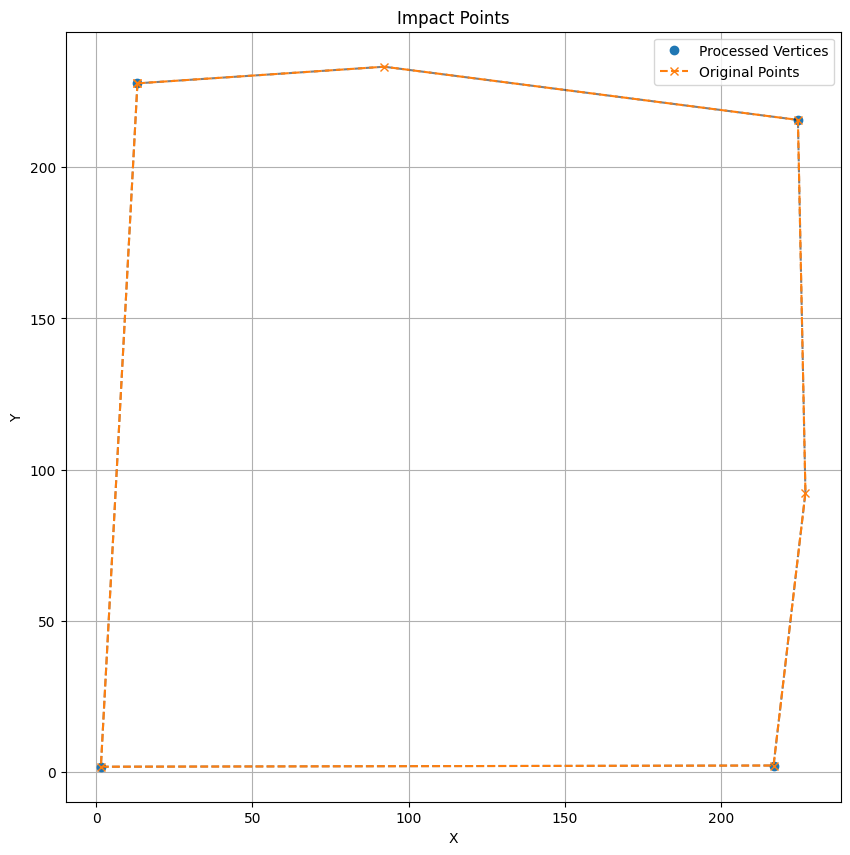

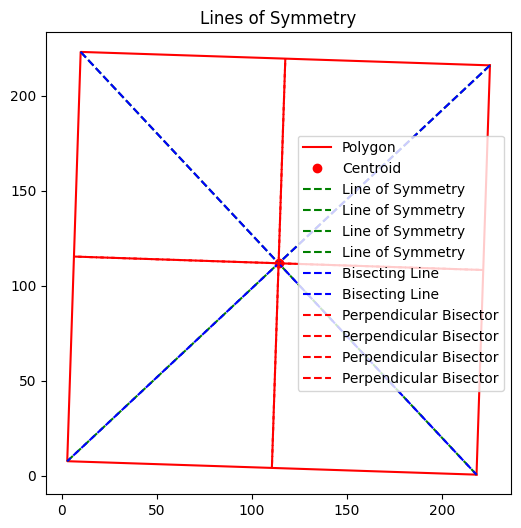

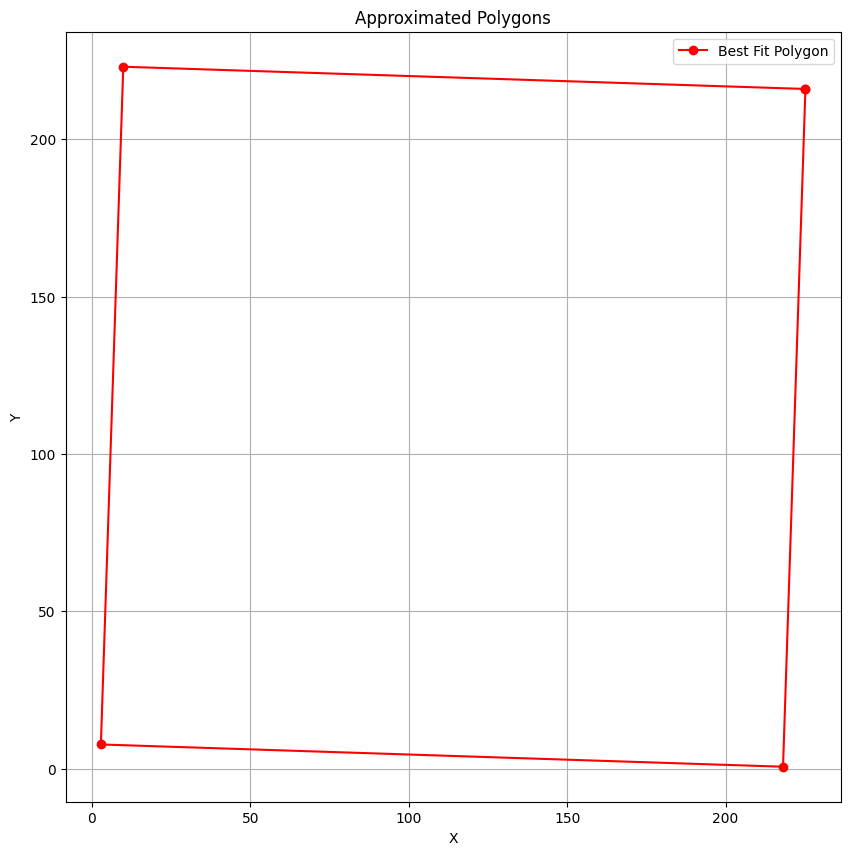

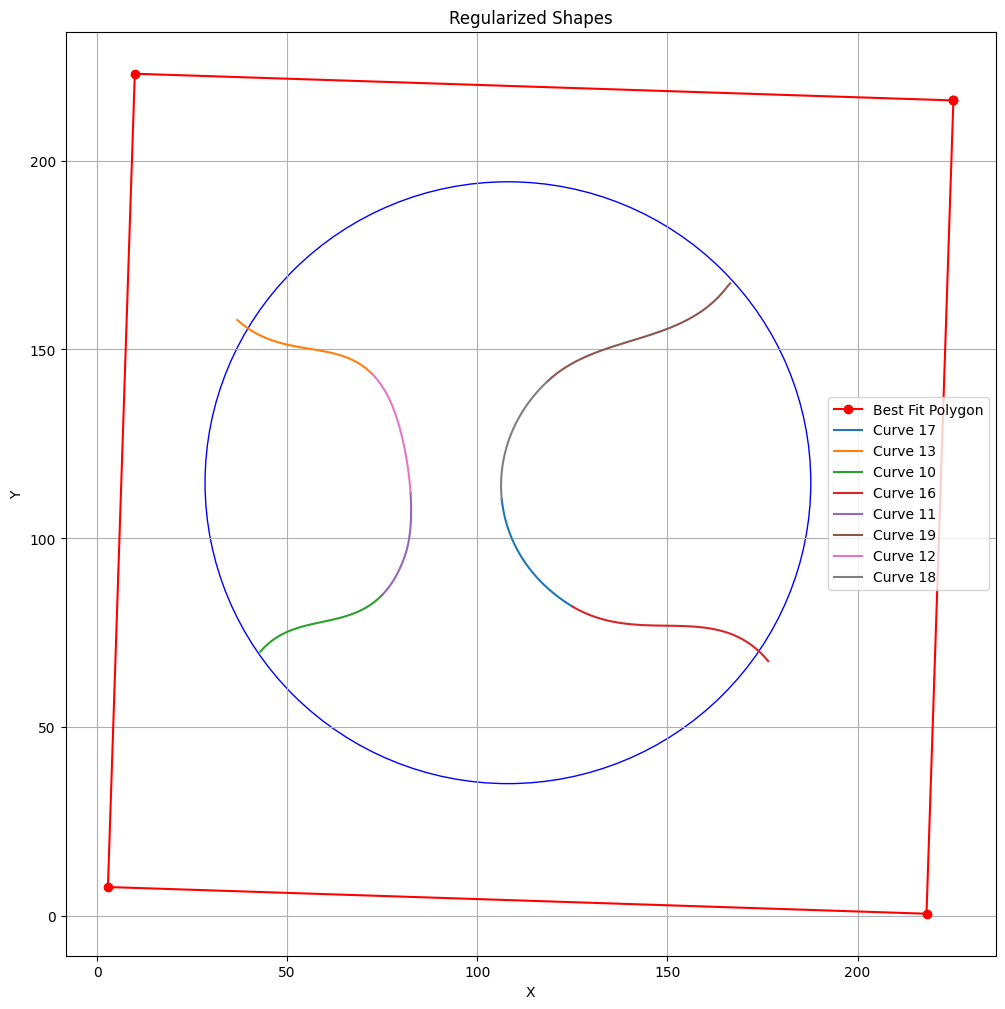

In [9]:
regularize("./data/problems/frag0.csv")

# OUTPUT

Test Case Name: **frag1**


try to fit circle in loops : 



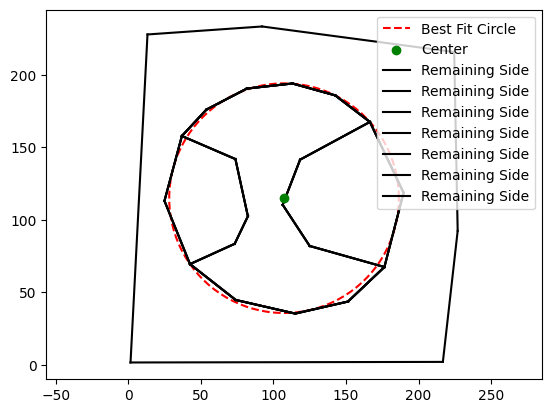

Mean Square Fitting Error: 3.8345


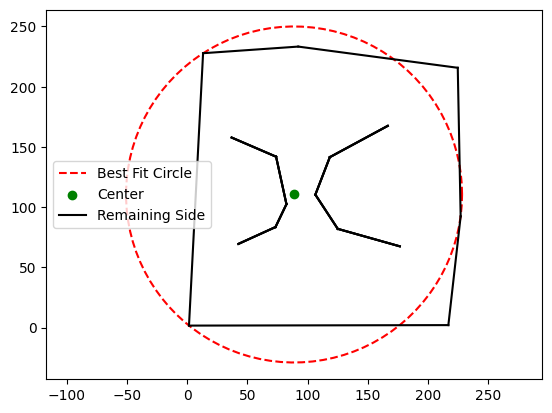

Mean Square Fitting Error: 400.6097
Final Possible Circles are : 


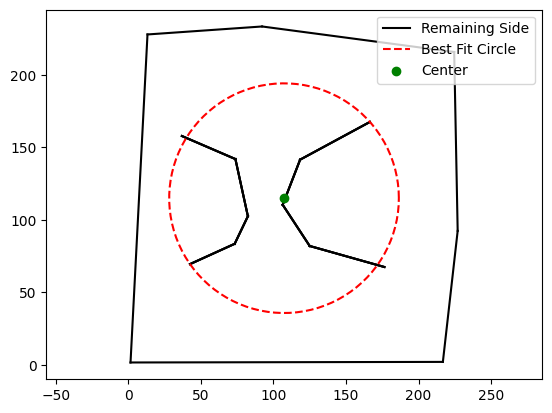

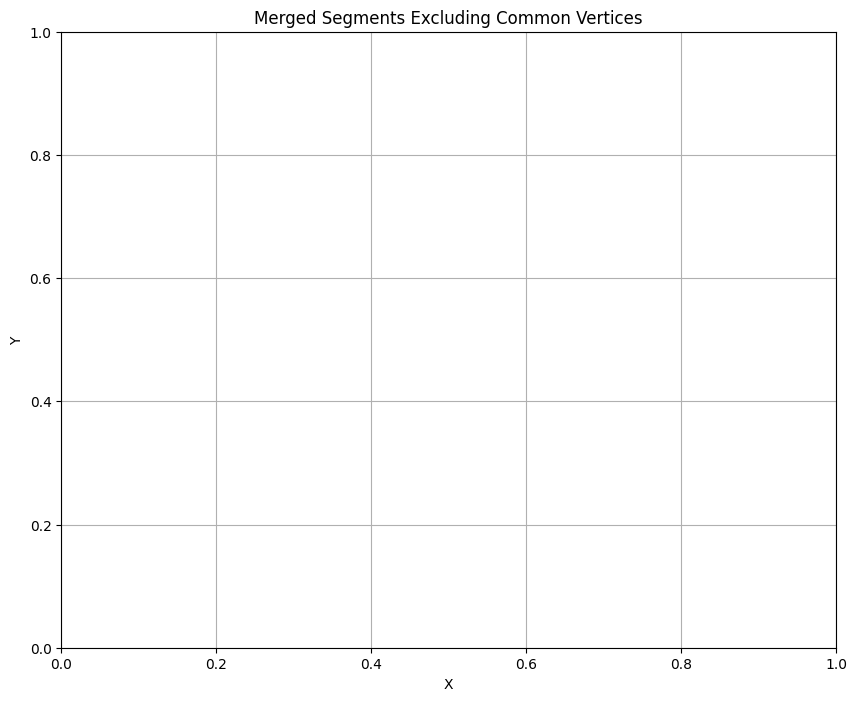

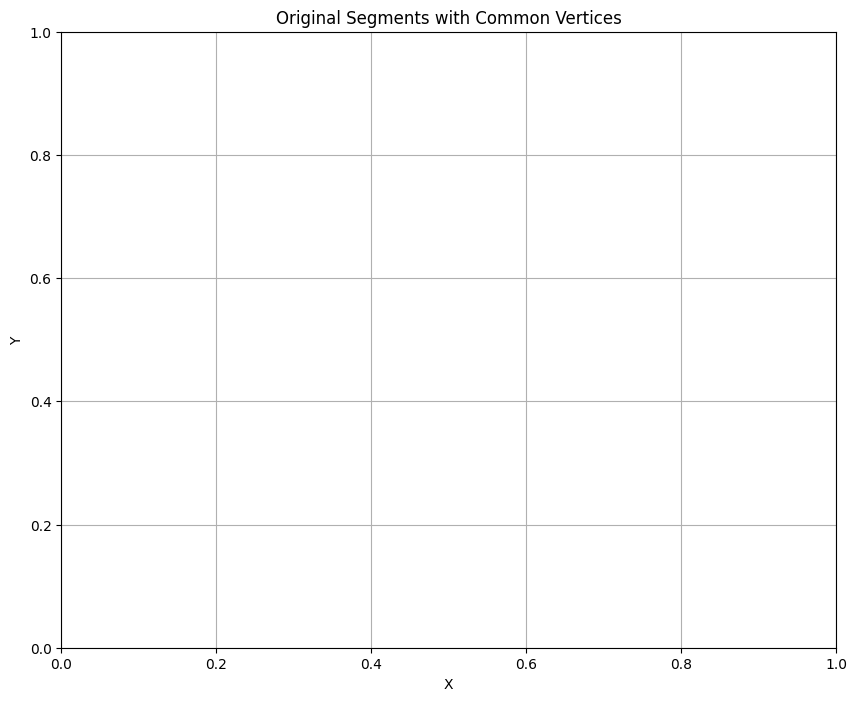

Impact Points in current loop are : 


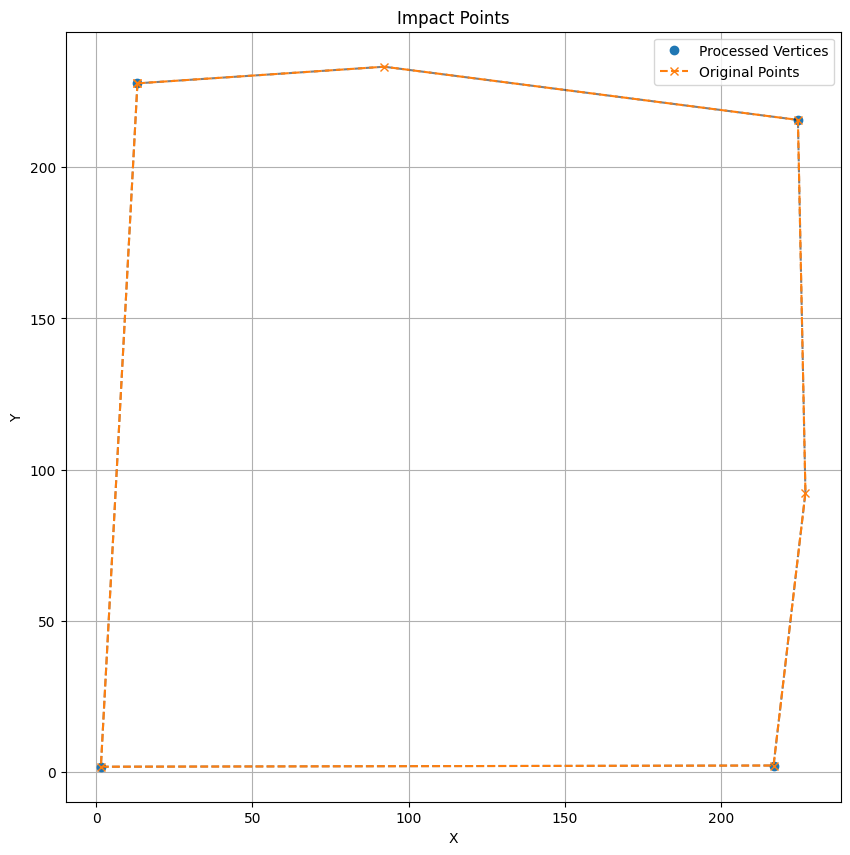

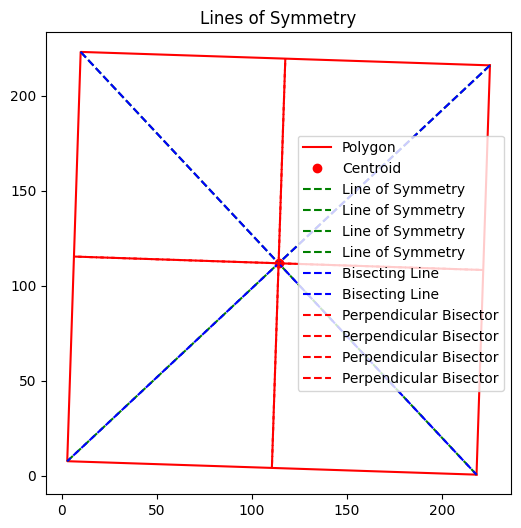

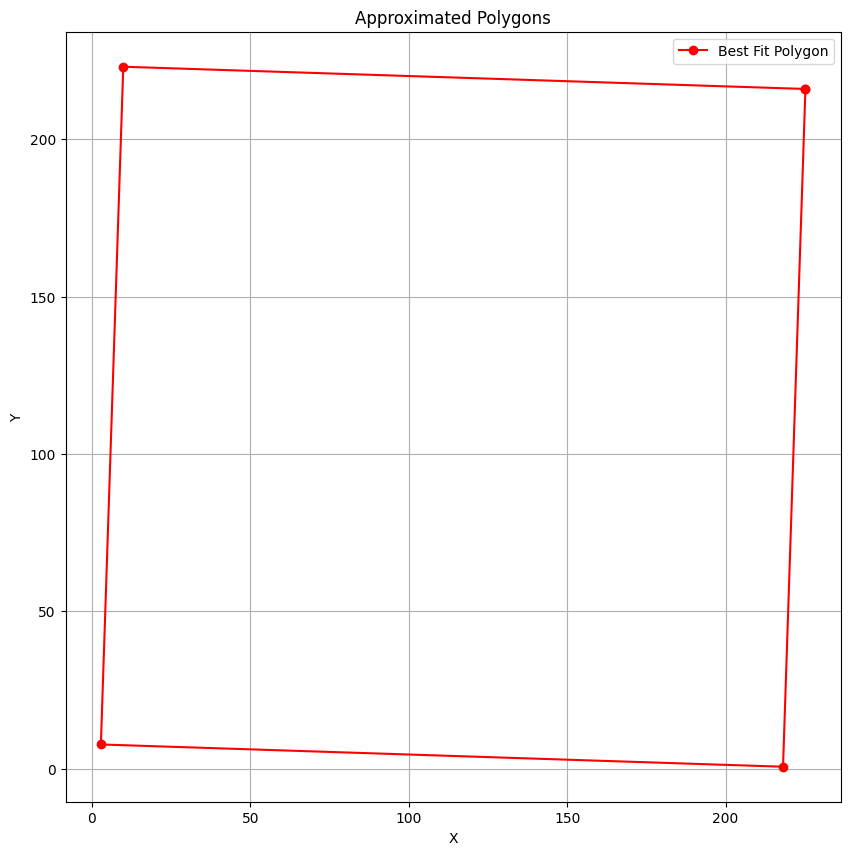

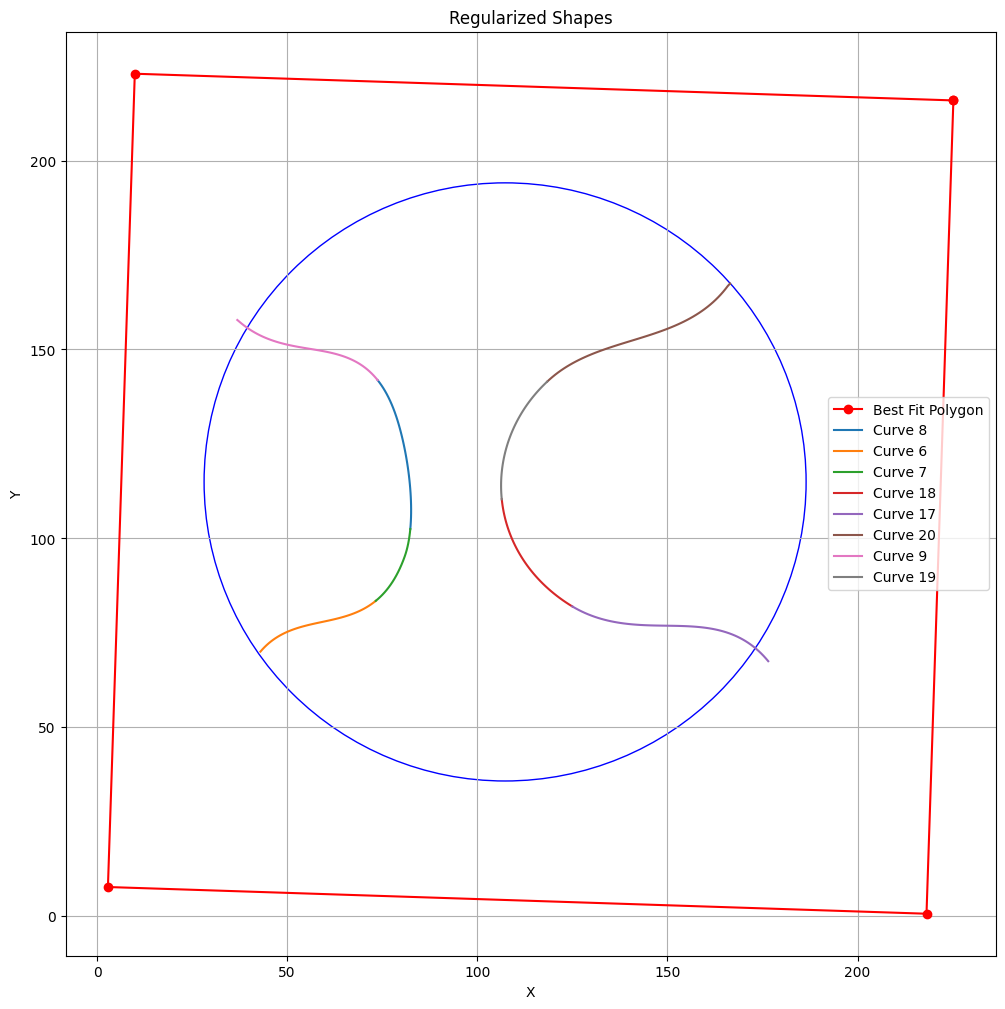

In [10]:
regularize("./data/problems/frag1.csv")

# OUTPUT

Test Case Name: **frag2**


try to fit circle in loops : 

Final Possible Circles are : 


/tmp/ipykernel_39719/1952205867.py:226: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


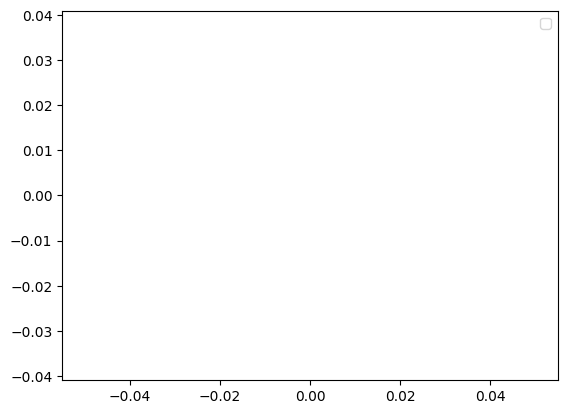

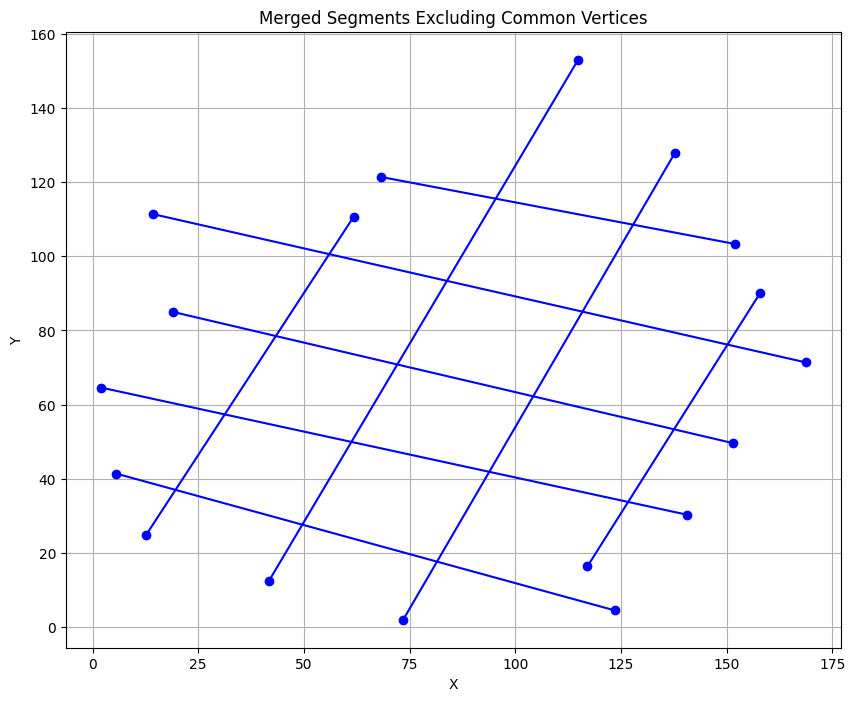

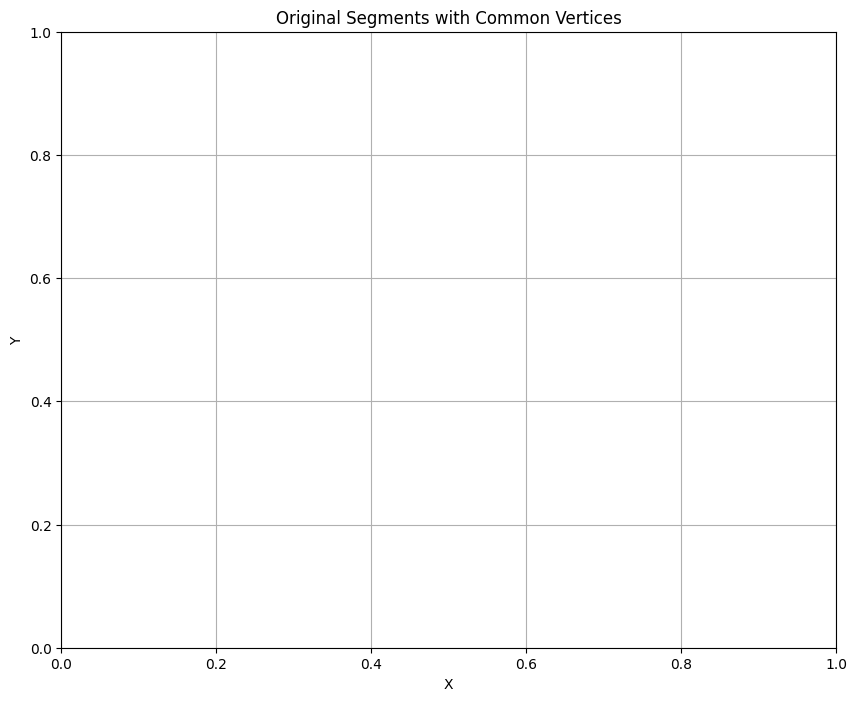

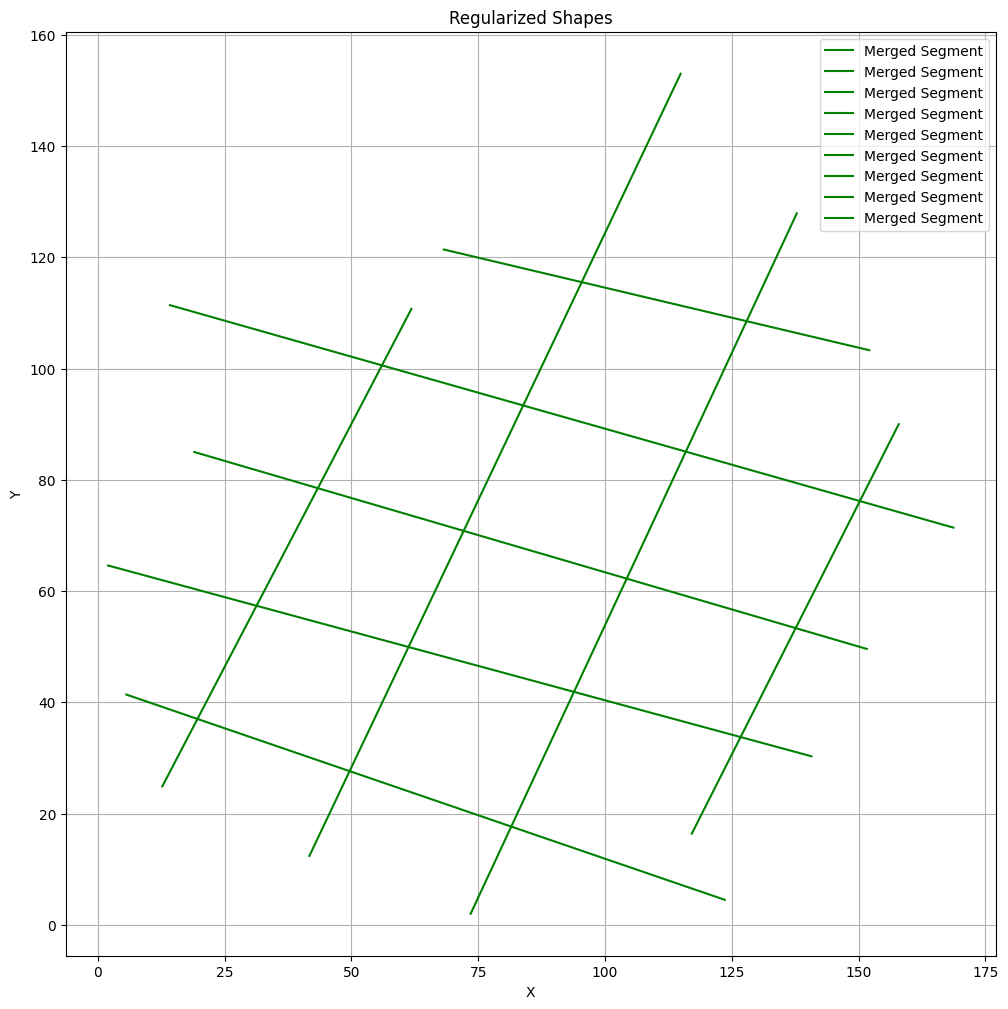

In [11]:
regularize("./data/problems/frag2.csv")

# OUTPUT

Test Case Name: **isolated**


try to fit circle in loops : 



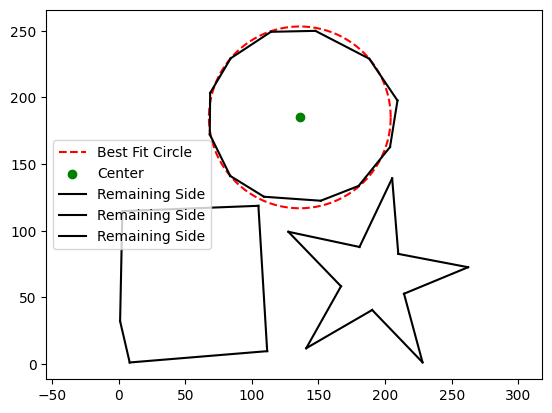

Mean Square Fitting Error: 8.3642


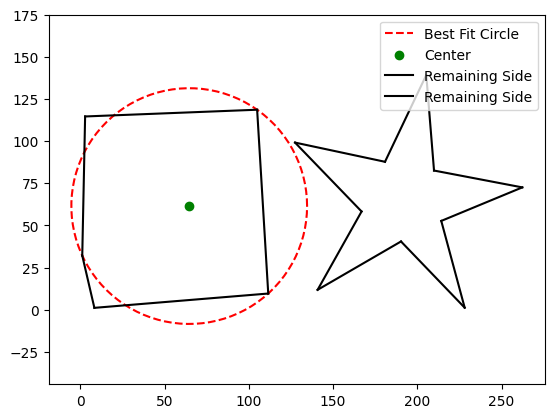

Mean Square Fitting Error: 123.3565


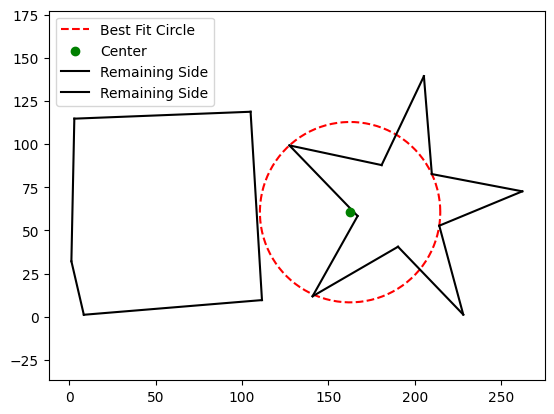

Mean Square Fitting Error: 512.3699
Final Possible Circles are : 


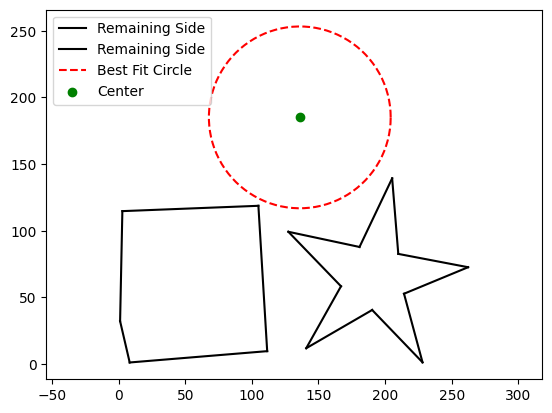

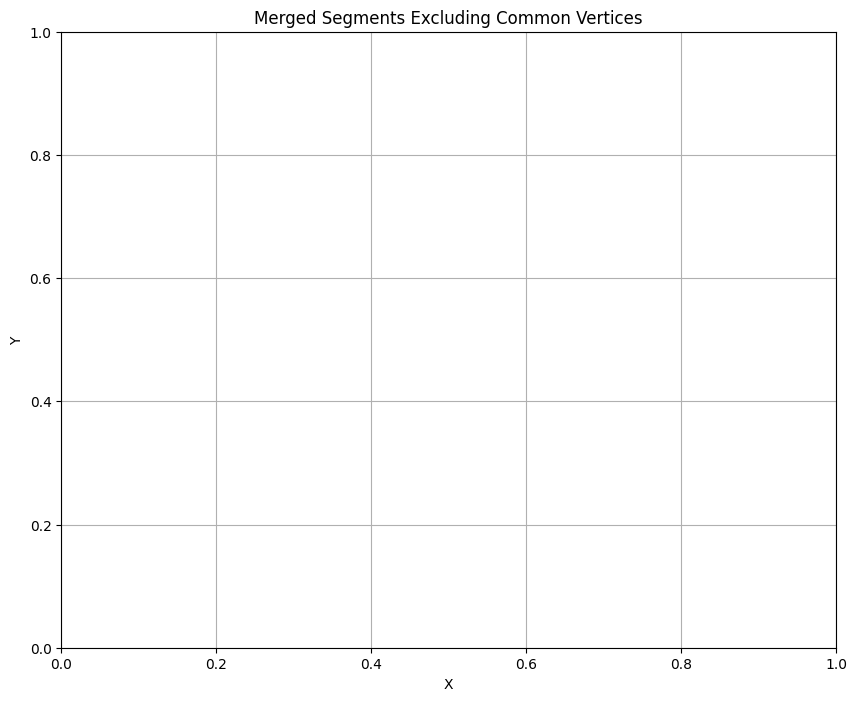

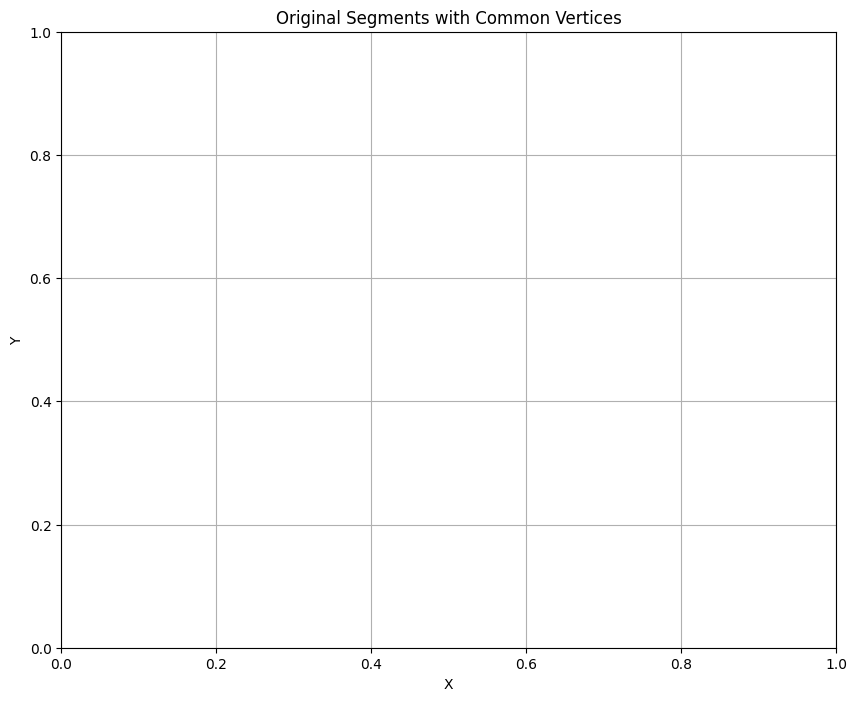

Impact Points in current loop are : 


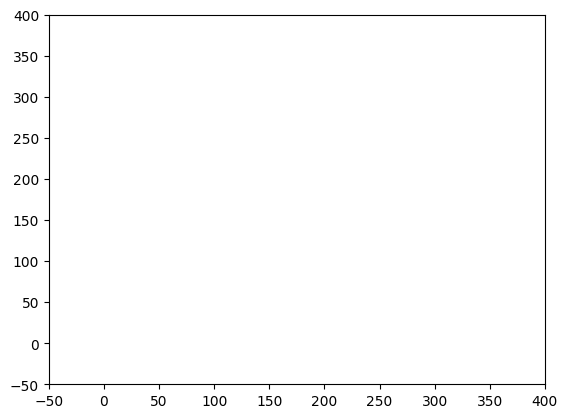

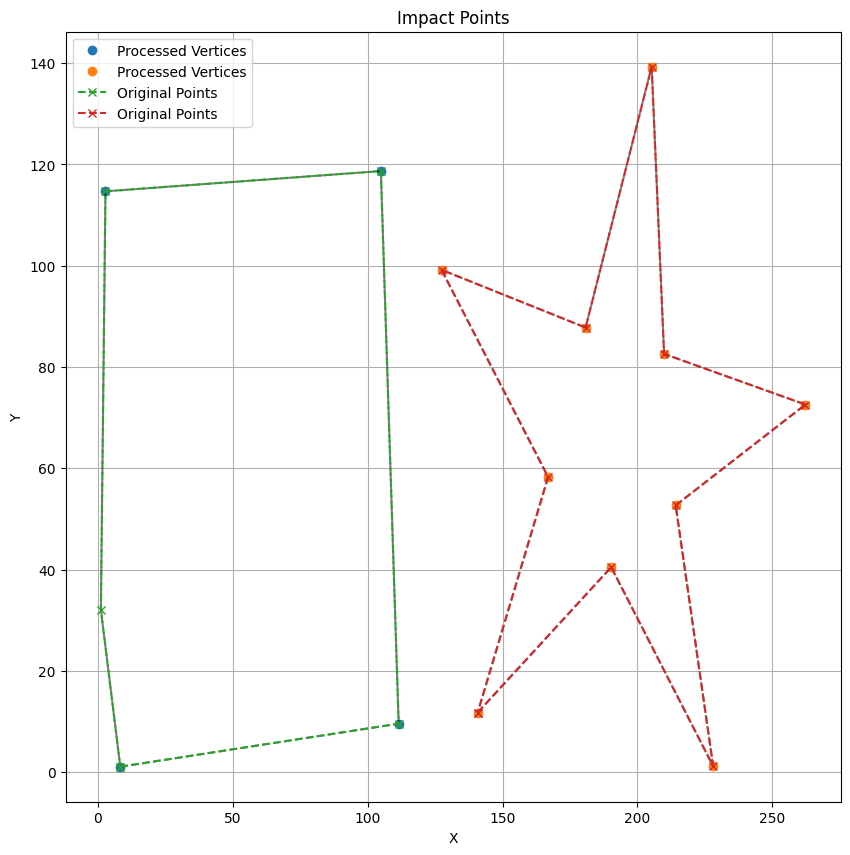

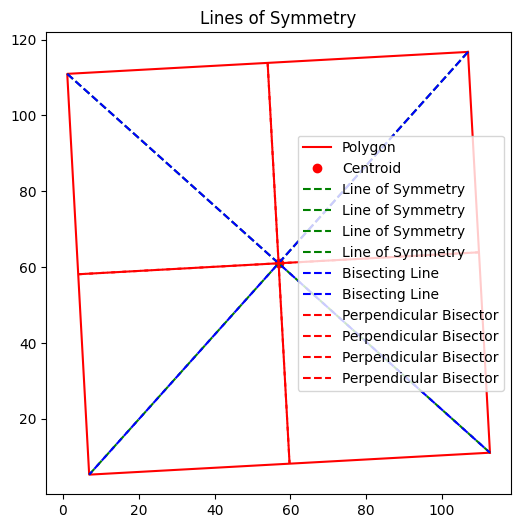

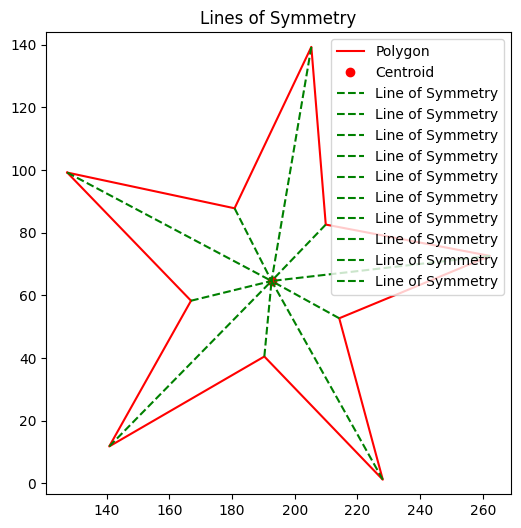

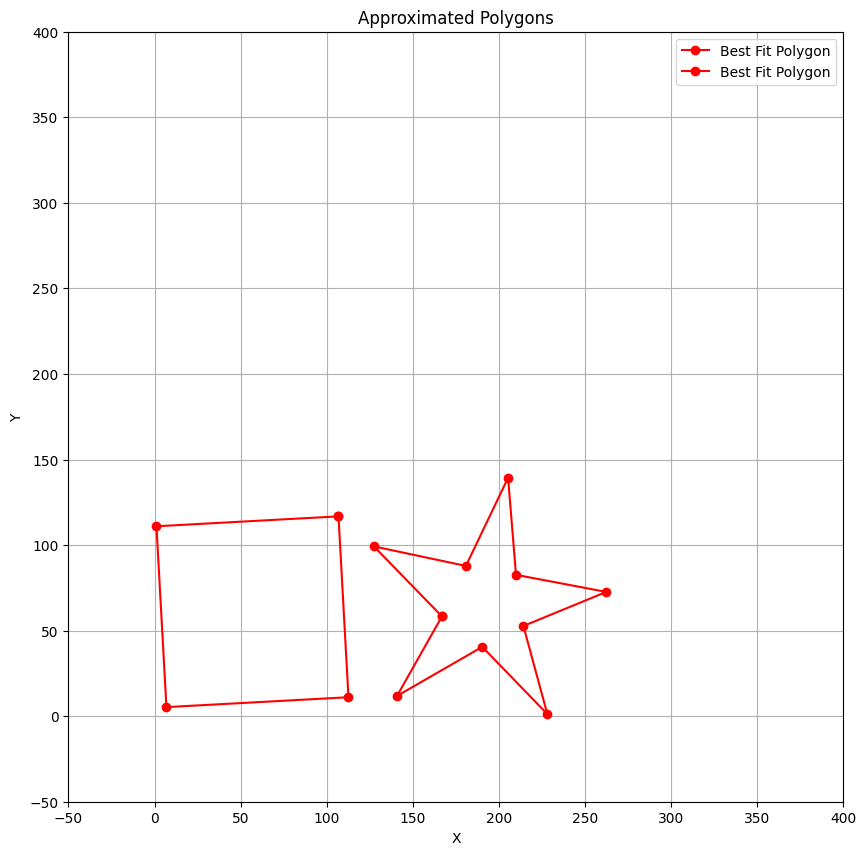

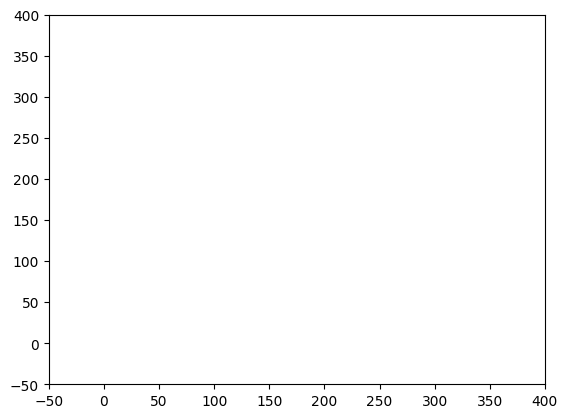

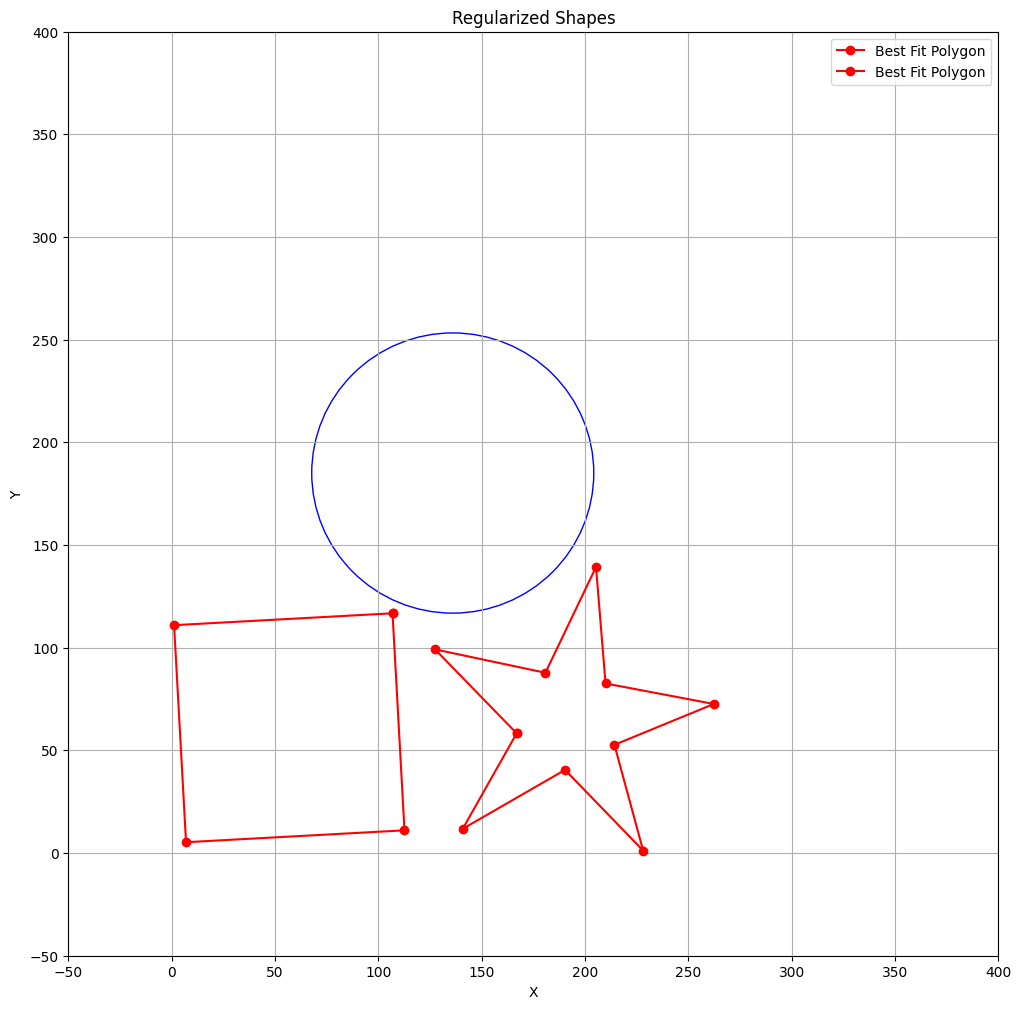

In [12]:
regularize("./data/problems/isolated.csv", 400, 400)